### Benchmark: perfect_hashing

In [1]:
!pyperf system tune

Tune the system configuration to run benchmarks

System state

CPU: use 16 logical CPUs: 0-15
Perf event: Maximum sample rate: 1 per second
ASLR: Full randomization
Linux scheduler: No CPU is isolated
CPU Frequency: 0-11=min=max=2300 MHz; 12-15=min=max=1700 MHz
CPU scaling governor (intel_pstate): performance
Turbo Boost (intel_pstate): Turbo Boost disabled
IRQ affinity: irqbalance service: inactive
IRQ affinity: Default IRQ affinity: CPU 0-15
Power supply: the power cable is plugged

Advices

Linux scheduler: Use isolcpus=<cpu list> kernel parameter to isolate CPUs
Linux scheduler: Use rcu_nocbs=<cpu list> kernel parameter (with isolcpus) to not schedule RCU on isolated CPUs

Errors

CPU Frequency: Unable to write scaling_max_freq of CPU 0: [Errno 13] Permission denied: '/sys/devices/system/cpu/cpu0/cpufreq/scaling_min_freq'
IRQ affinity: Failed to write '0000ffff' into /proc/irq/166/smp_affinity: [Errno 13] Permission denied: '/proc/irq/166/smp_affinity'
ERROR: At least one operation

In [255]:
!lstopo-no-graphics --no-io --no-legend
!cat /proc/cpuinfo | grep -m 1 -A 26 '^processor'
!getconf -a | grep CACHE

Machine (62GB total) + Package L#0
  NUMANode L#0 (P#0 62GB)
  L3 L#0 (24MB)
    L2 L#0 (1280KB) + L1d L#0 (48KB) + L1i L#0 (32KB) + Core L#0
      PU L#0 (P#0)
      PU L#1 (P#1)
    L2 L#1 (1280KB) + L1d L#1 (48KB) + L1i L#1 (32KB) + Core L#1
      PU L#2 (P#2)
      PU L#3 (P#3)
    L2 L#2 (1280KB) + L1d L#2 (48KB) + L1i L#2 (32KB) + Core L#2
      PU L#4 (P#4)
      PU L#5 (P#5)
    L2 L#3 (1280KB) + L1d L#3 (48KB) + L1i L#3 (32KB) + Core L#3
      PU L#6 (P#6)
      PU L#7 (P#7)
    L2 L#4 (1280KB) + L1d L#4 (48KB) + L1i L#4 (32KB) + Core L#4
      PU L#8 (P#8)
      PU L#9 (P#9)
    L2 L#5 (1280KB) + L1d L#5 (48KB) + L1i L#5 (32KB) + Core L#5
      PU L#10 (P#10)
      PU L#11 (P#11)
    L2 L#6 (2048KB)
      L1d L#6 (32KB) + L1i L#6 (64KB) + Core L#6 + PU L#12 (P#12)
      L1d L#7 (32KB) + L1i L#7 (64KB) + Core L#7 + PU L#13 (P#13)
      L1d L#8 (32KB) + L1i L#8 (64KB) + Core L#8 + PU L#14 (P#14)
      L1d L#9 (32KB) + L1i L#9 (64KB) + Core L#9 + PU L#15 (P#15)
processor	: 0
ven

In [365]:
import os
import numpy as np

TMP='/dev/shm'
CXXFLAGS='-std=c++20 -DNDEBUG -Ofast -march=native'
LDDFLAGS=''

def buildit(name, compiler, target, size, cfg):
    !rm -f {' '.join([f"{TMP}/{target}" for target in targets])}
    CMD=f"CXX={compiler} CXXFLAGS=\"{CXXFLAGS}\" LDDFLAGS=\"{LDDFLAGS}\" SIZE={size} PROBABILITY={cfg['probability']} SEED={cfg['seed']} TMP={TMP} BENCHMARK={name} /usr/bin/time -f %e make -j -s"
    time = !{CMD} {target}
    assert _exit_code == 0
    try:
        return float(time[0])
    except:
        print(time)
    
def timeit(target, cpu = 1, runs = 3):
    times = []
    checksums = []
    !strip {TMP}/{target}
    for _ in range(runs):
        result = !taskset -c {cpu} {TMP}/{target}
        tokens = result[0].split(':')
        times.append(float(tokens[1]))
        checksums.append(int(tokens[0]))
    print('.', end='')
    binary_size = !stat -c %s {TMP}/{target}
    return times, checksums, int(binary_size[0])

In [381]:
import joblib, random, string
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

gperf="""
struct data {
  const char* key;
  int value;
};
%compare-strncmp
%language=C++
%enum
%includes
%readonly-tables
%global-table
%struct-type
%define slot-name key
%define lookup-function-name find
%%
"""

def generate_integers(size, rng):
    result = []
    for i in range(size):
        while True:
          new = random.randint(rng[0], rng[1])
          if new not in result:
            result.append(new)
            break
    return result

def generate_strings(size, length):
    result = []
    for i in range(size):
        while True:
          new = ''.join(random.choices(string.ascii_letters + string.digits, k=random.randint(length[0], length[1])))
          if new not in result:
            result.append(new)
            break
    return result

def generate(filename, size, cfg):
  if 'length' in cfg:
    data = generate_strings(size, cfg['length'])
    with open(filename + ".ipp", 'w') as file:
      for index, name in enumerate(data):
          file.write(f"std::pair{{\"{name}\"sv, {index + 1}}},\n")
    with open(filename + ".gperf", 'w') as file:
      file.write(gperf)
      for index, name in enumerate(data):
          file.write(f"\"{name}\", {index + 1}\n")
    return data
  elif 'range' in cfg:
    data = generate_integers(size, cfg['range'])
    with open(filename + ".ipp", 'w') as file:
      for index, value in enumerate(data):
          file.write(f"std::pair{{{value}, {index + 1}}},\n")
    return data

def benchmark(name, compilers, targets, sizes, combinations):
    for combination in combinations:
        _, ax_time   = plt.subplots(1, len(compilers), figsize=(22, 7))
        _, ax_build  = plt.subplots(1, len(compilers), figsize=(22, 7))
        _, ax_binary = plt.subplots(1, len(compilers), figsize=(22, 7))
        hashed_checksums = defaultdict(list)
        y_min = [np.iinfo(np.uint32).max, np.iinfo(np.uint32).max, np.iinfo(np.uint32).max]
        y_max = [np.iinfo(np.uint32).min, np.iinfo(np.uint32).min, np.iinfo(np.uint32).min]

        for i, compiler in enumerate(compilers):
            times = defaultdict(list)
            builds = defaultdict(list)
            binaries = defaultdict(list)

            for size in sizes:
                data = generate(f"{TMP}/data", size, combination)
                
                for target in targets:
                    time = buildit(name, compiler, target, size, combination)
                    builds[target].append(time)
                    ts, checksums, binary_size = timeit(target)
                    times[target].append(np.median(ts))
                    binaries[target].append(binary_size)
                    assert len(checksums) > 0 and all(checksum == checksums[0] for checksum in checksums), f"{compiler}, {target}, {size}, {combination}, {checksums}"
                    hash = joblib.hash([data, combination])
                    hashed_checksums[hash].append(checksums[0])
                    assert all(checksum == hashed_checksums[hash][0] for checksum in hashed_checksums[hash]), f"{compiler}, {target}, {size}, {combination}, {hashed_checksums[hash]}"

            def update(ax, n, data, title):
                for target, data in data.items():
                    ax[i].plot(sizes, data, marker='o', markersize=3, label=target)
                    y_min[n] = min(y_min[n], min(data))
                    y_max[n] = max(y_max[n], max(data))

                ax[i].set_title(title, fontsize=9)
                ax[i].grid(True)
                for spine in ax[i].spines.values():
                    spine.set_visible(False)
                ax[i].set_xlabel('size')
                ax[i].set_ylabel('time [s]')
                ax[i].ticklabel_format(style='plain', axis='both')
                ax[i].legend(loc='upper left')
            
            update(ax_time, 0, times, f"[{name} - lookup time]\ncompiler: {compiler}, cxxflags: {CXXFLAGS}" + " \n" + f"{', '.join([f'{name}:{value}' for name, value in combination.items()])}")
            update(ax_build, 1, builds, f"[{name} - build time]\ncompiler: {compiler}, cxxflags: {CXXFLAGS}" + " \n" + f"{', '.join([f'{name}:{value}' for name, value in combination.items()])}")
            update(ax_binary, 2, binaries, f"[{name} - binary size (stripped)]\ncompiler: {compiler}, cxxflags: {CXXFLAGS}" + " \n" + f"{', '.join([f'{name}:{value}' for name, value in combination.items()])}")

        def ylim(ax, n):
            ax[1].yaxis.tick_right()
            for i in range(len(compilers)):
                ax[i].set_ylim(y_min[n], y_max[n] * 1.1)

        ylim(ax_time, 0)
        ylim(ax_build, 1)
        ylim(ax_binary, 2)
        
        plt.tight_layout()
        plt.show()

................................................................................................................

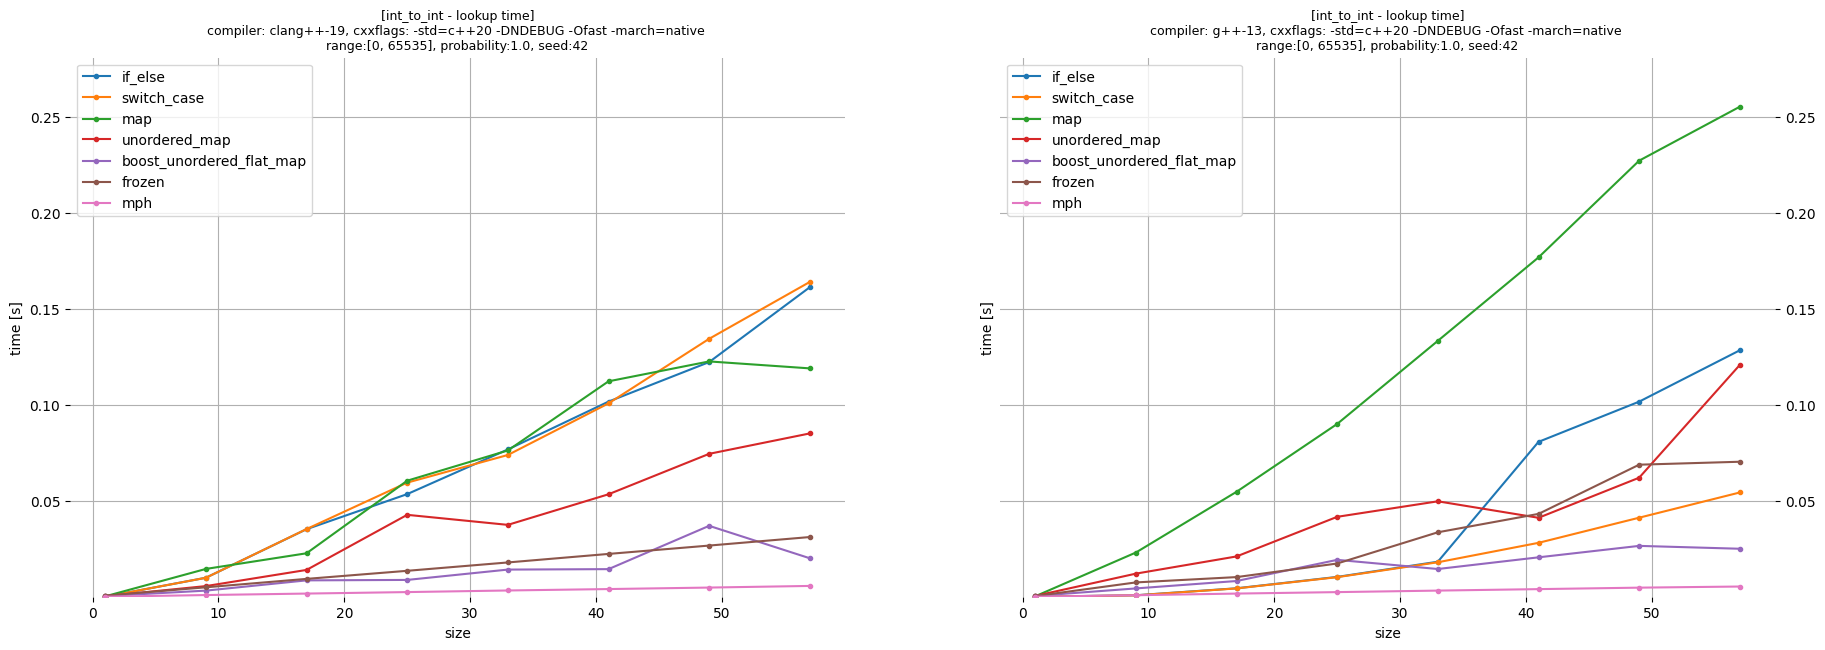

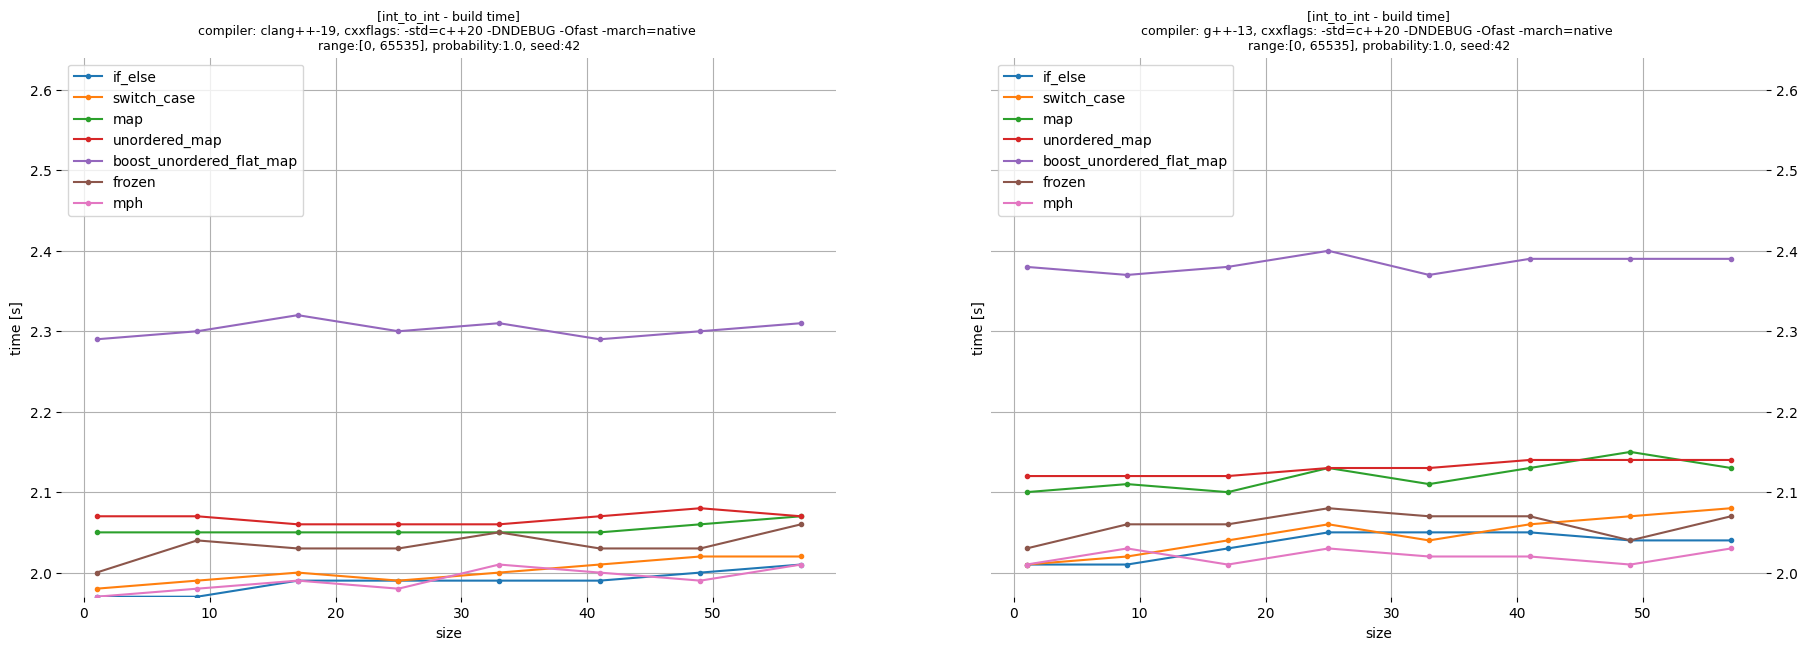

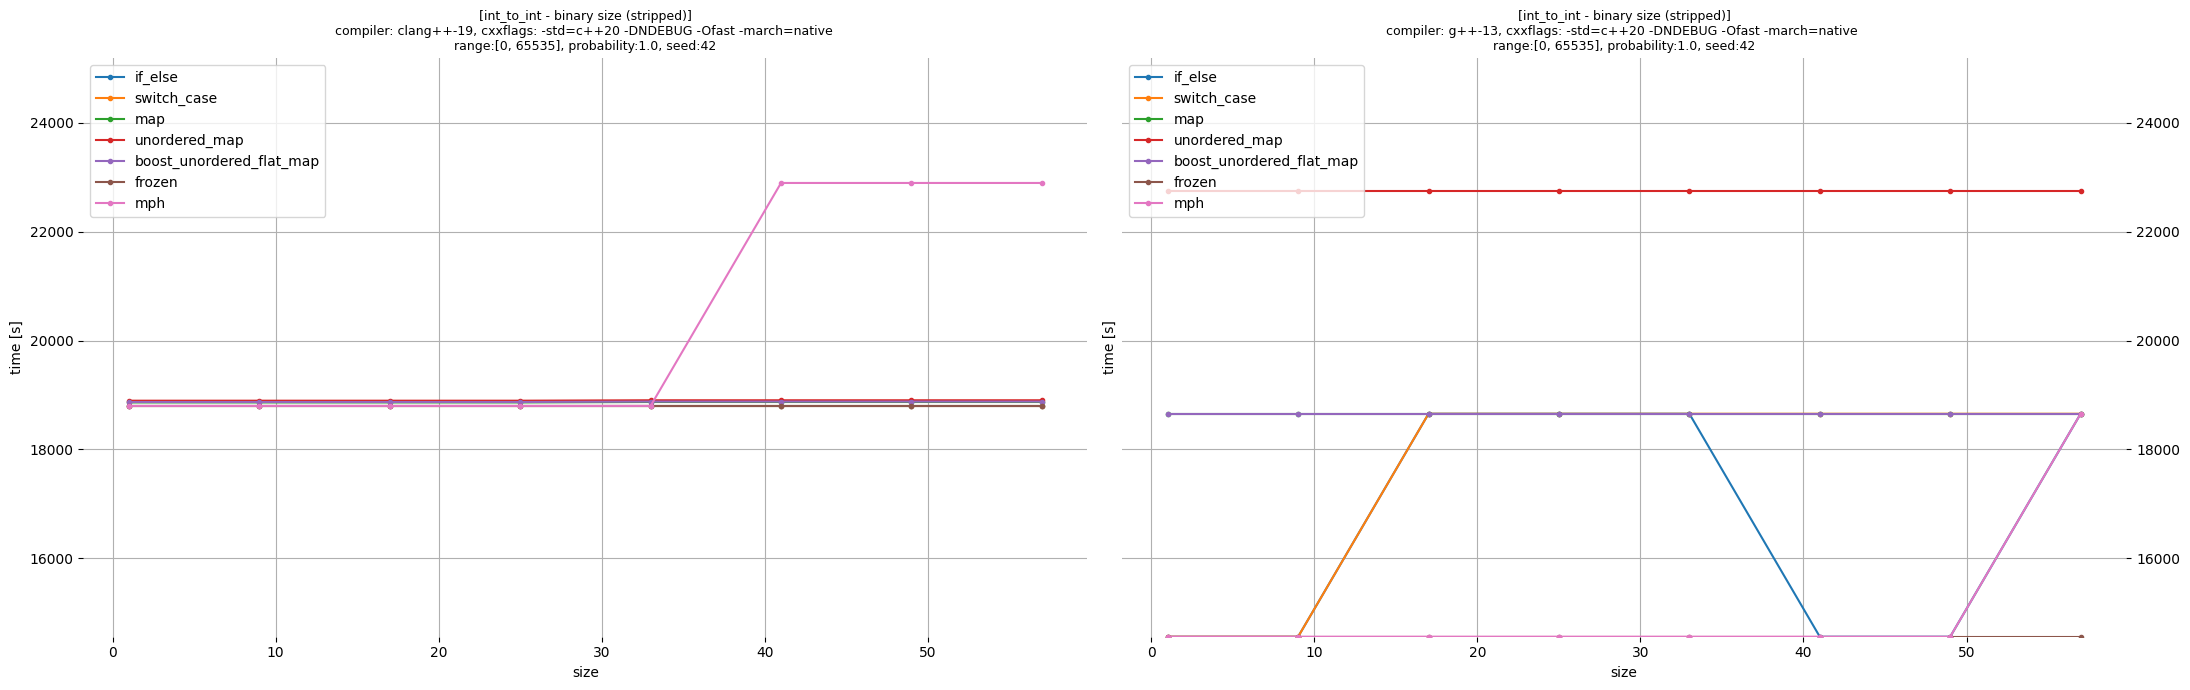

................................................................................................................

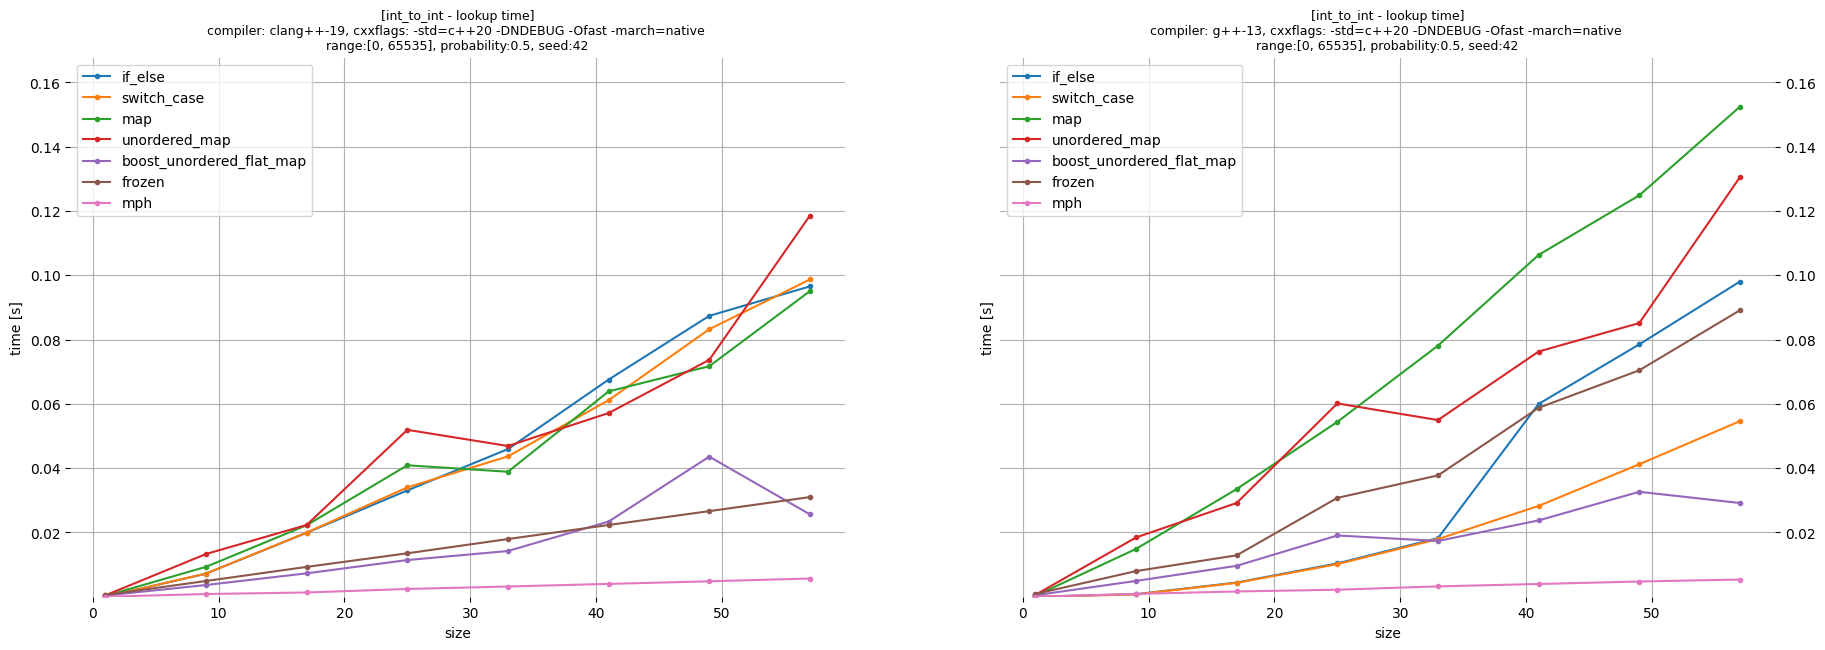

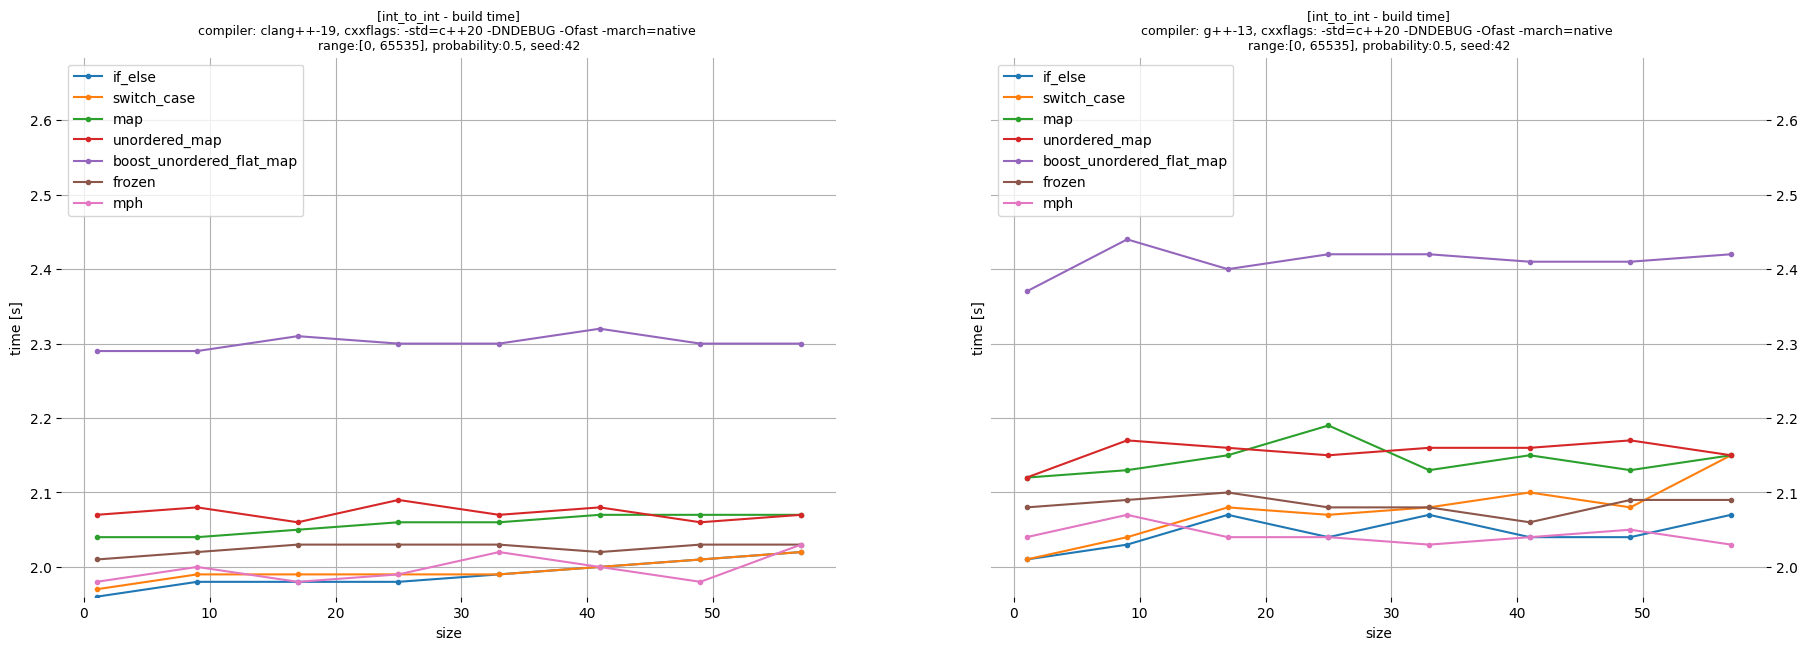

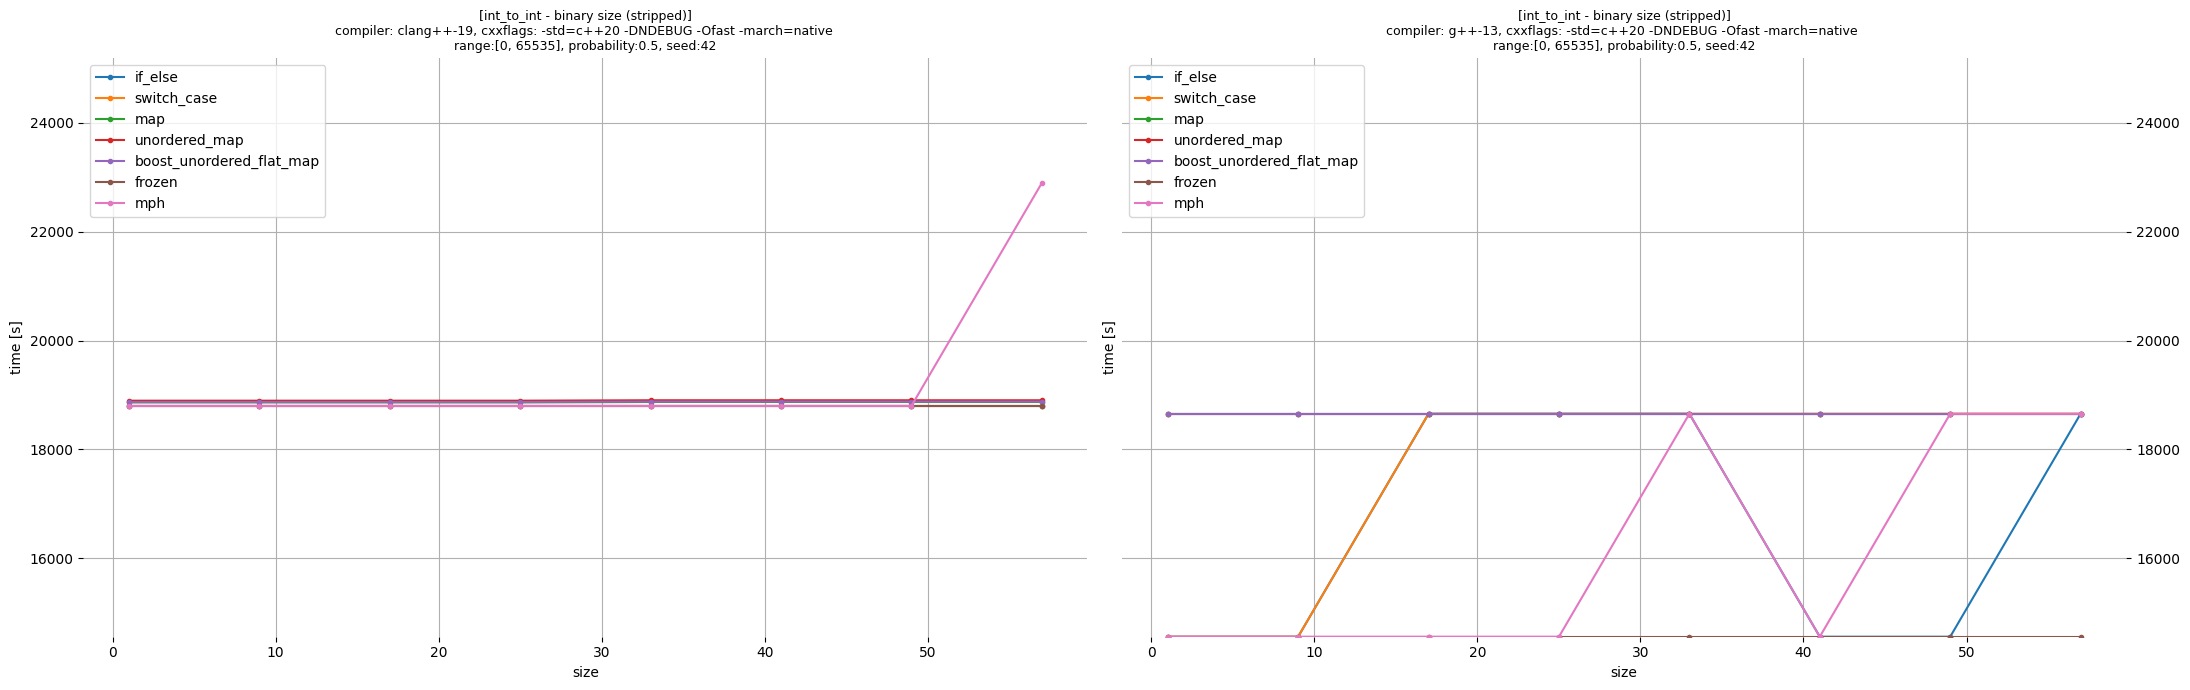

................................................................................................................

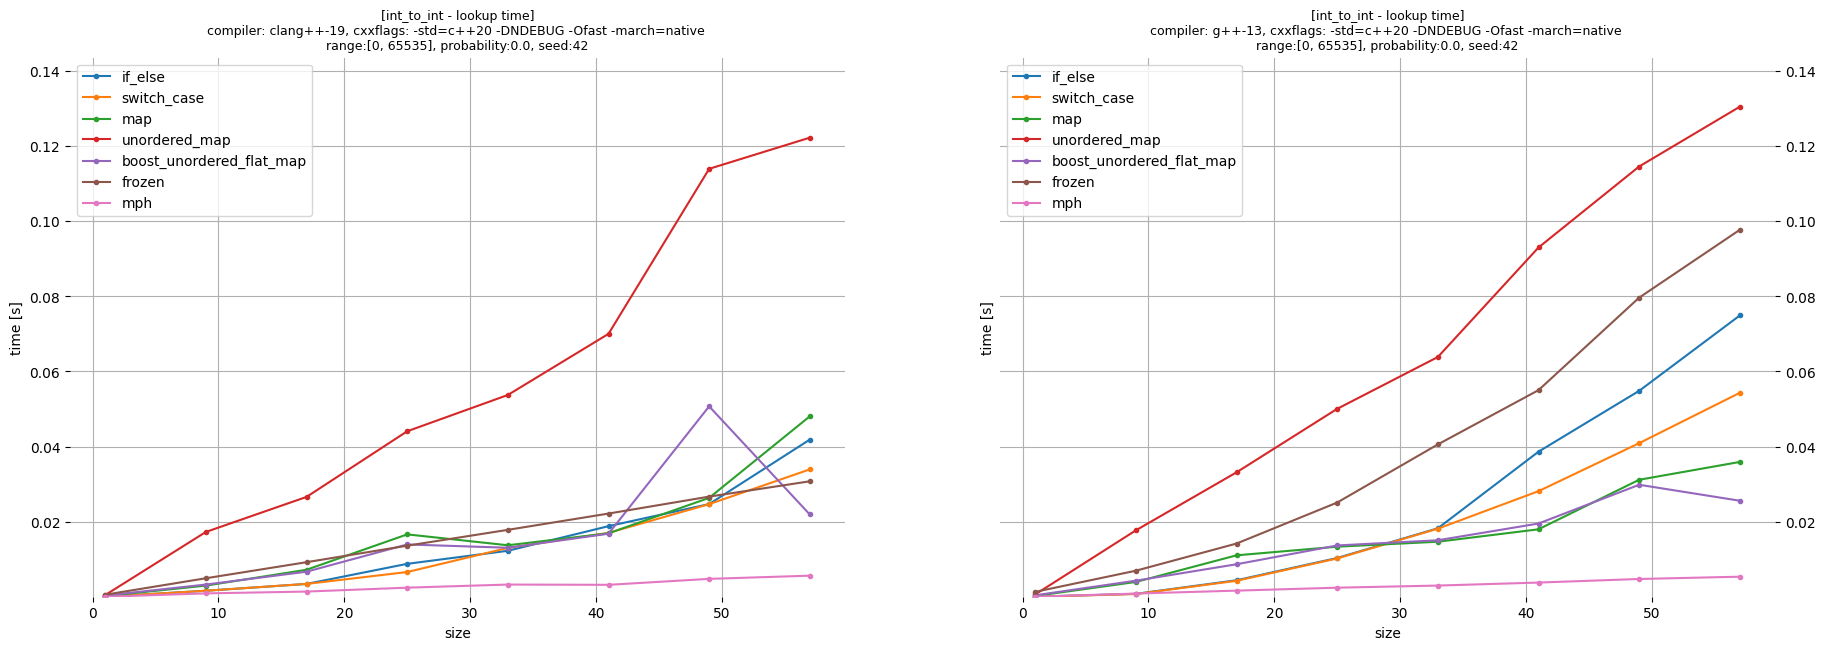

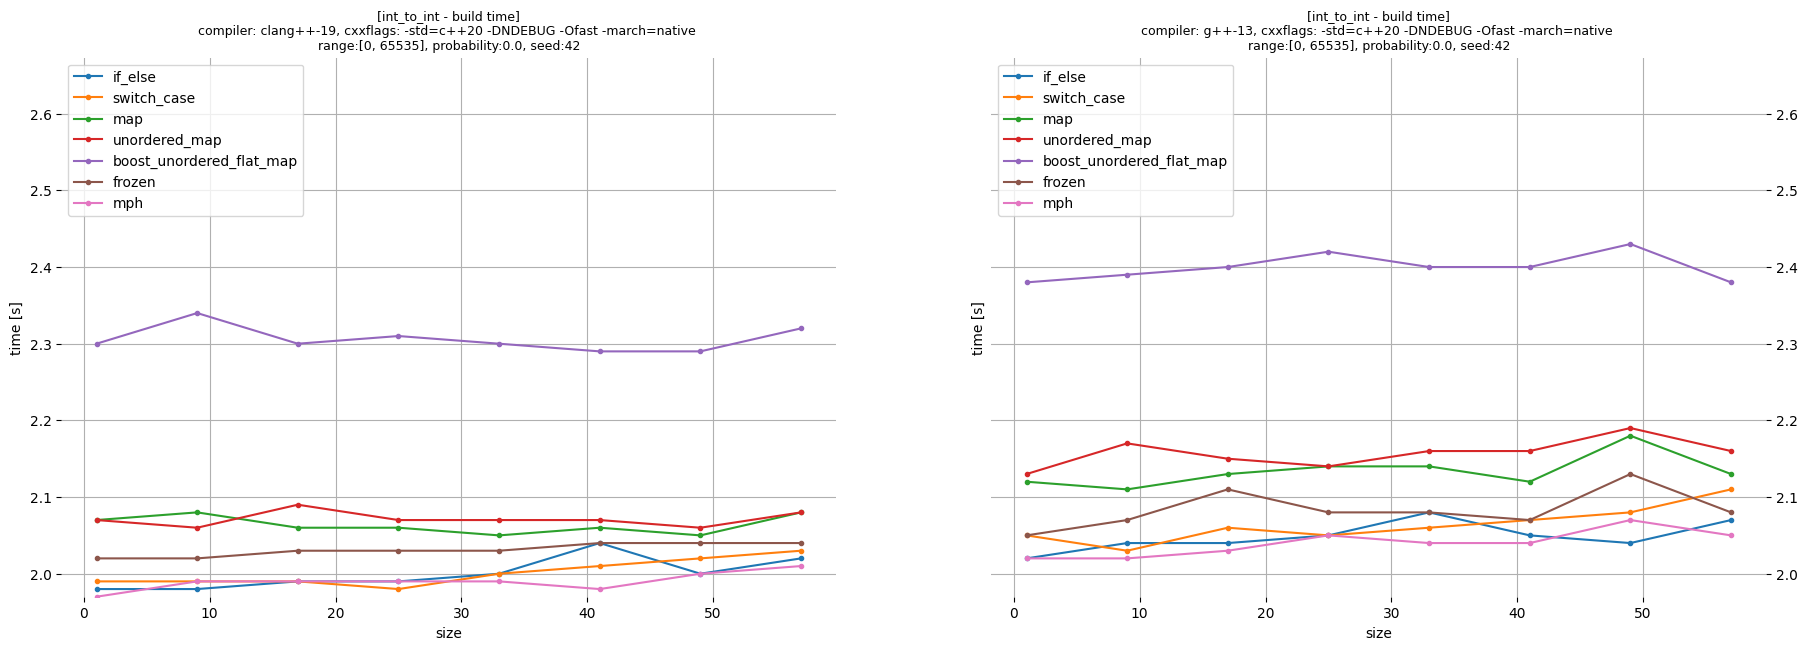

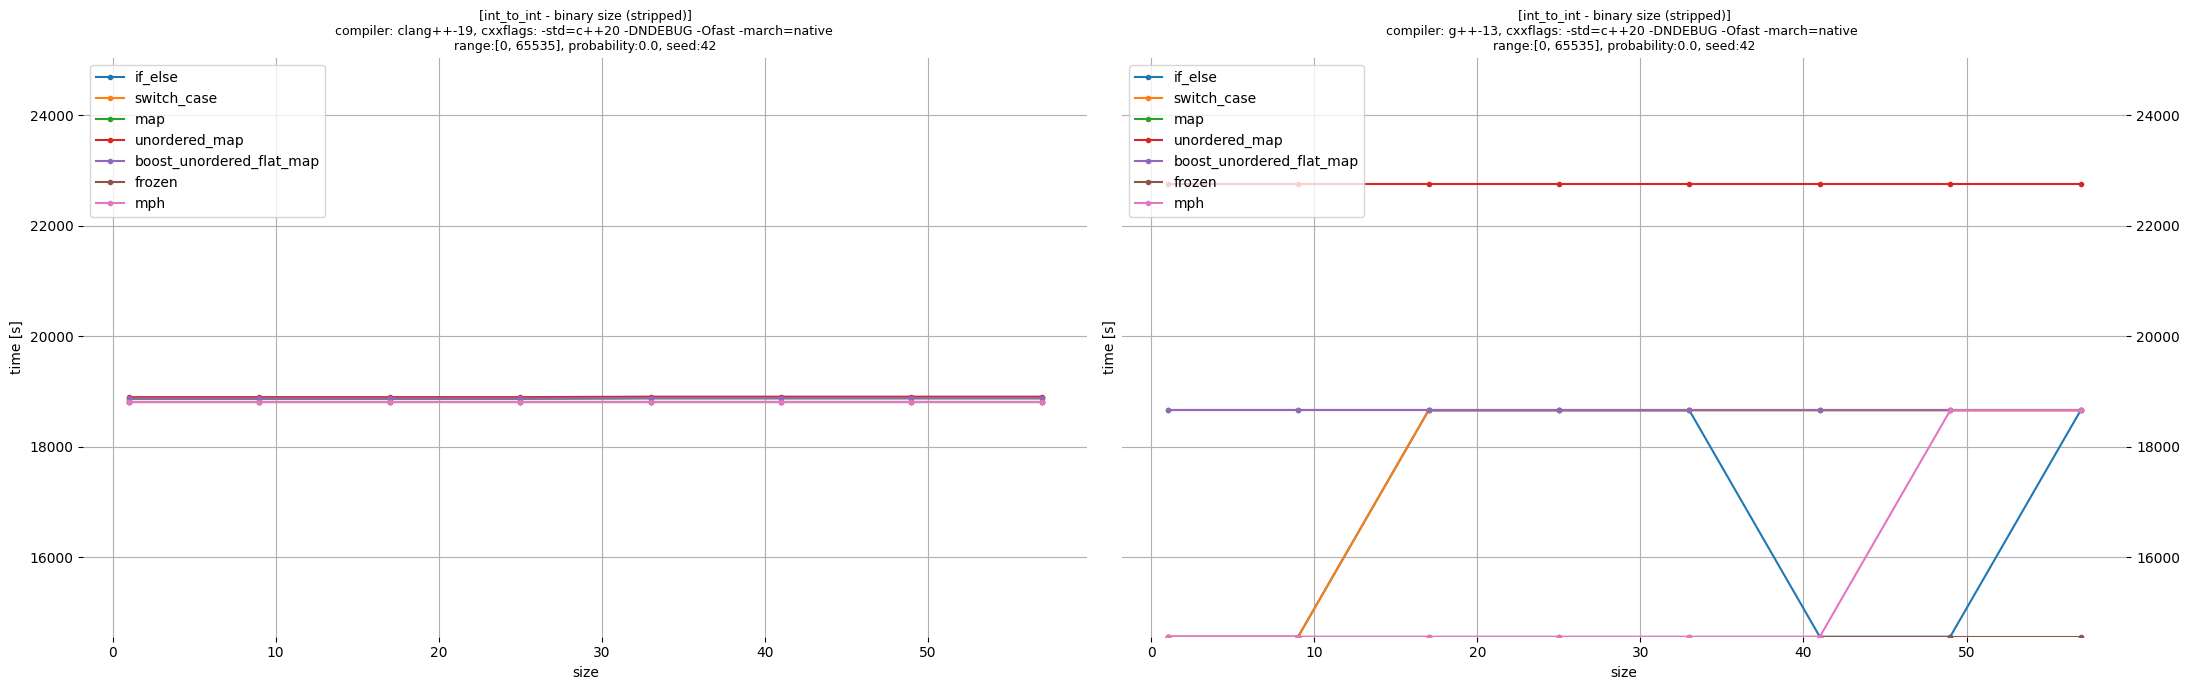

................................................................

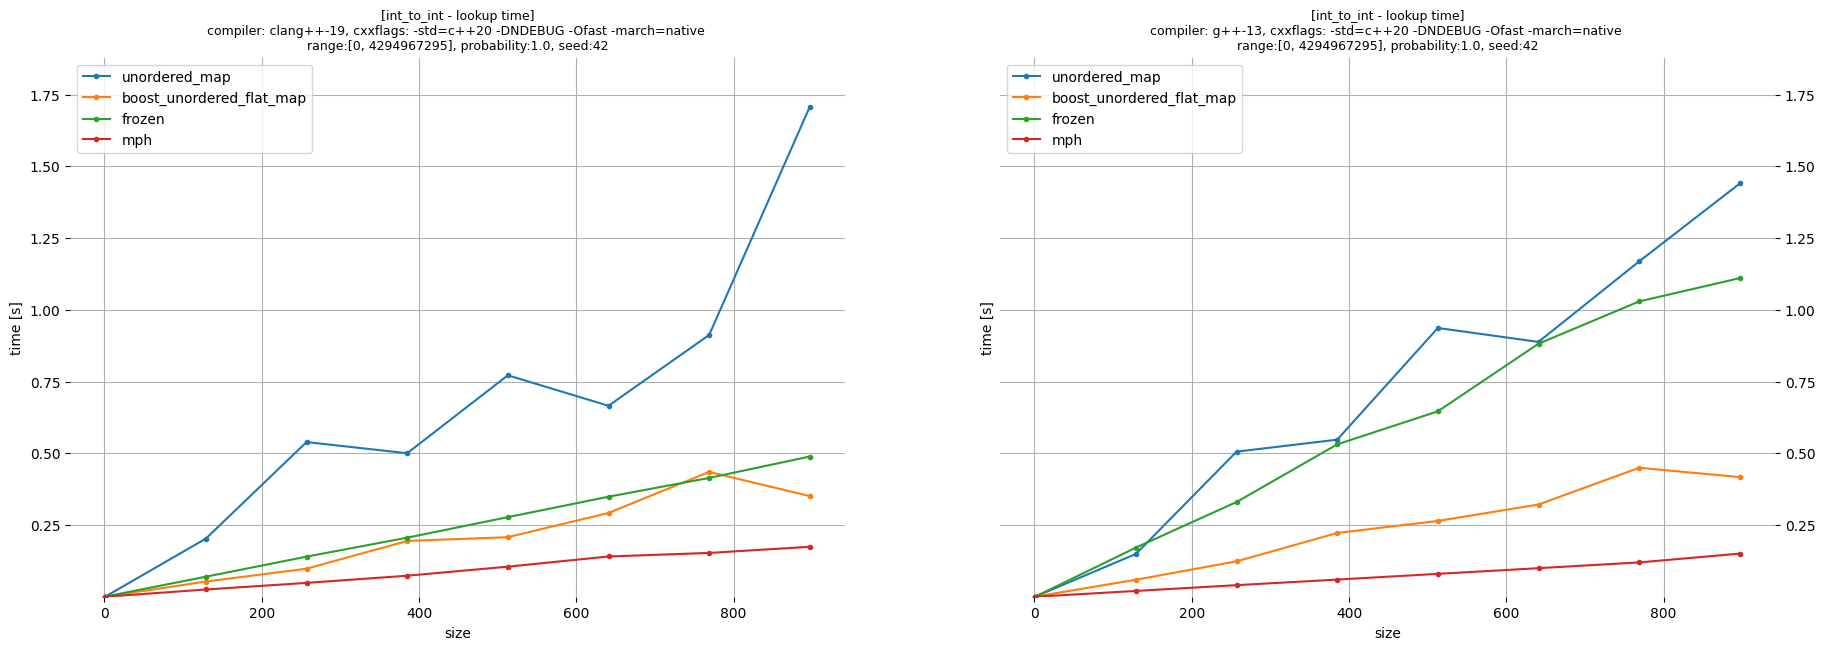

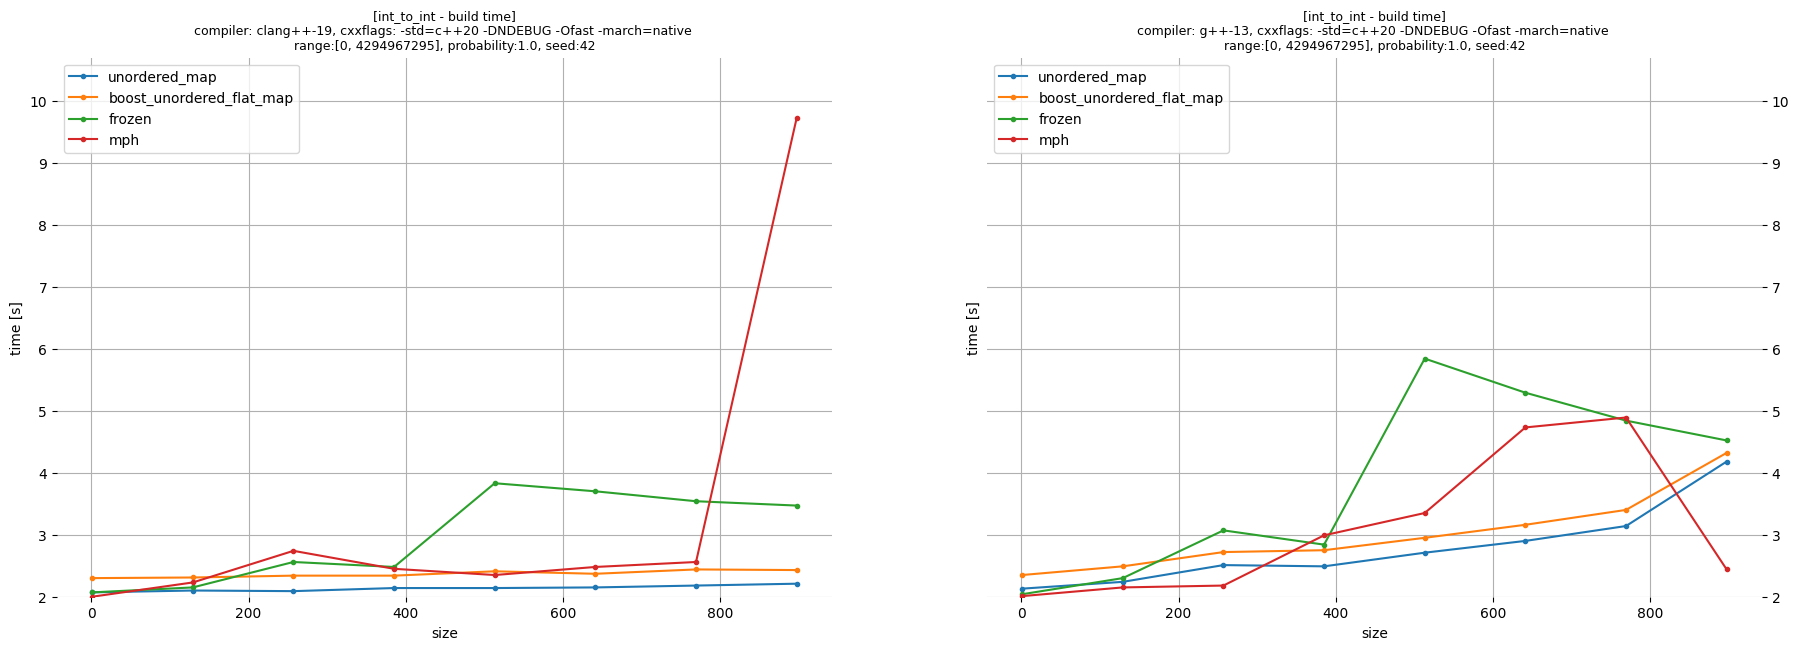

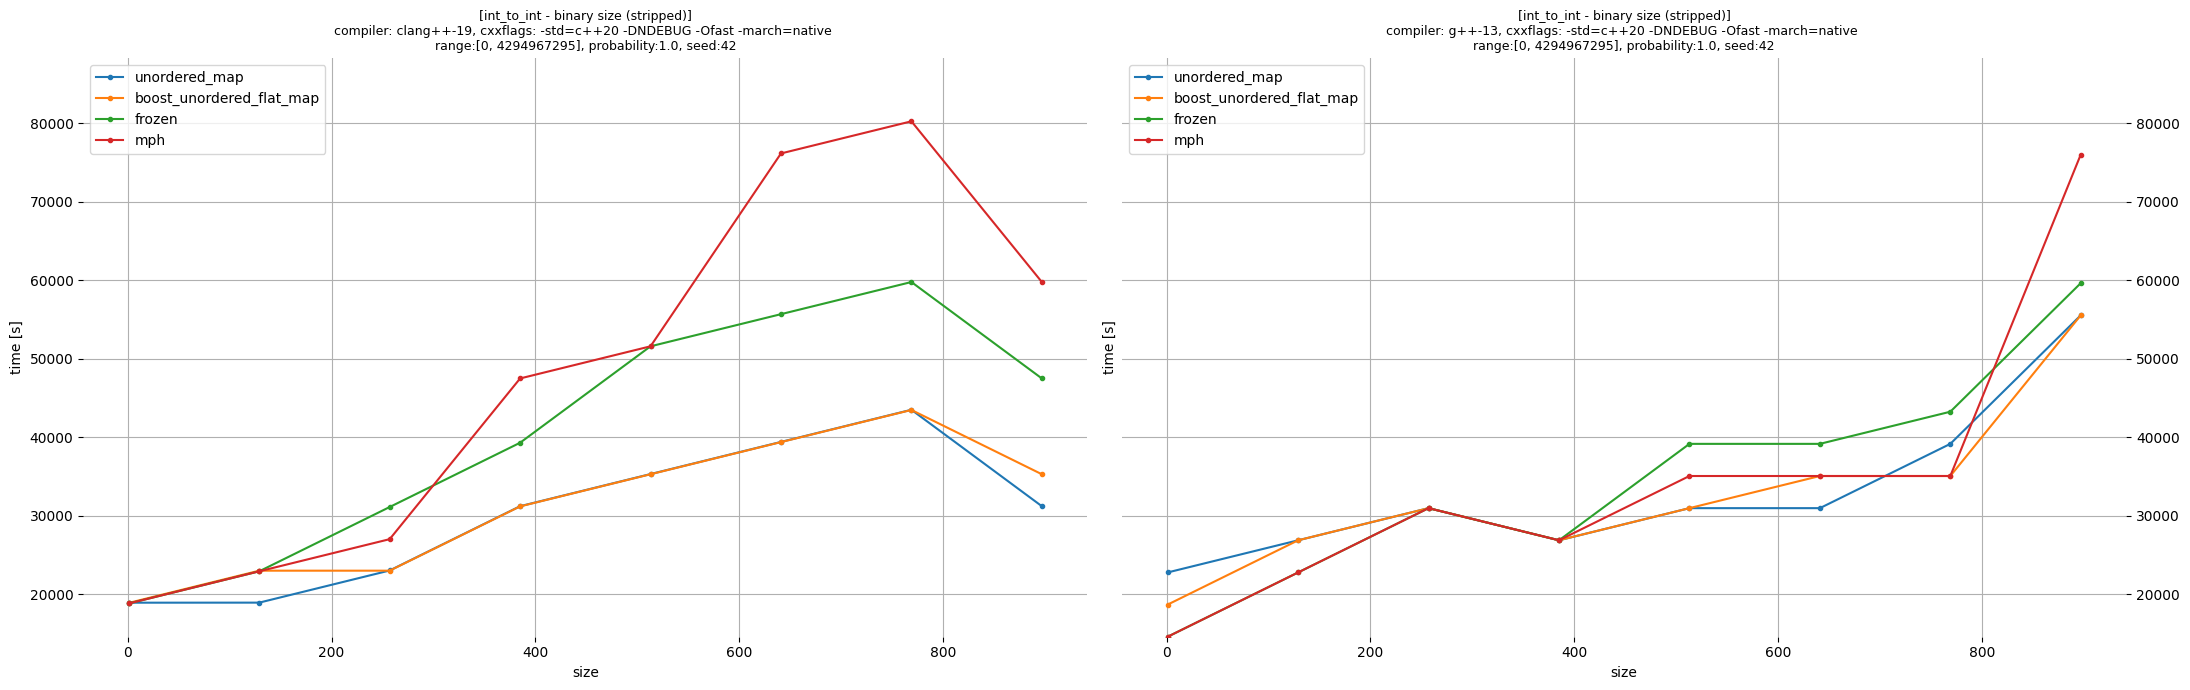

................................................................

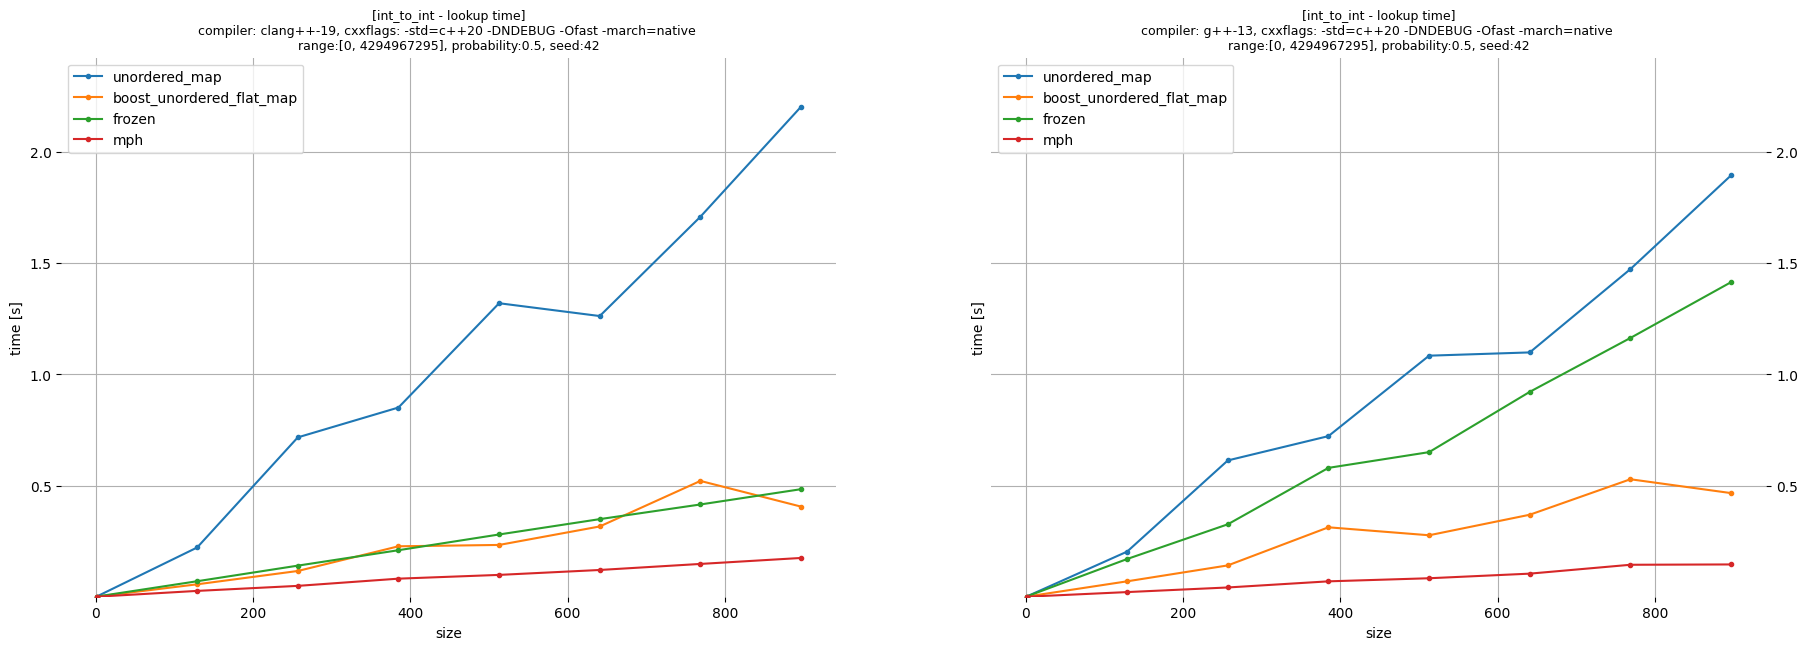

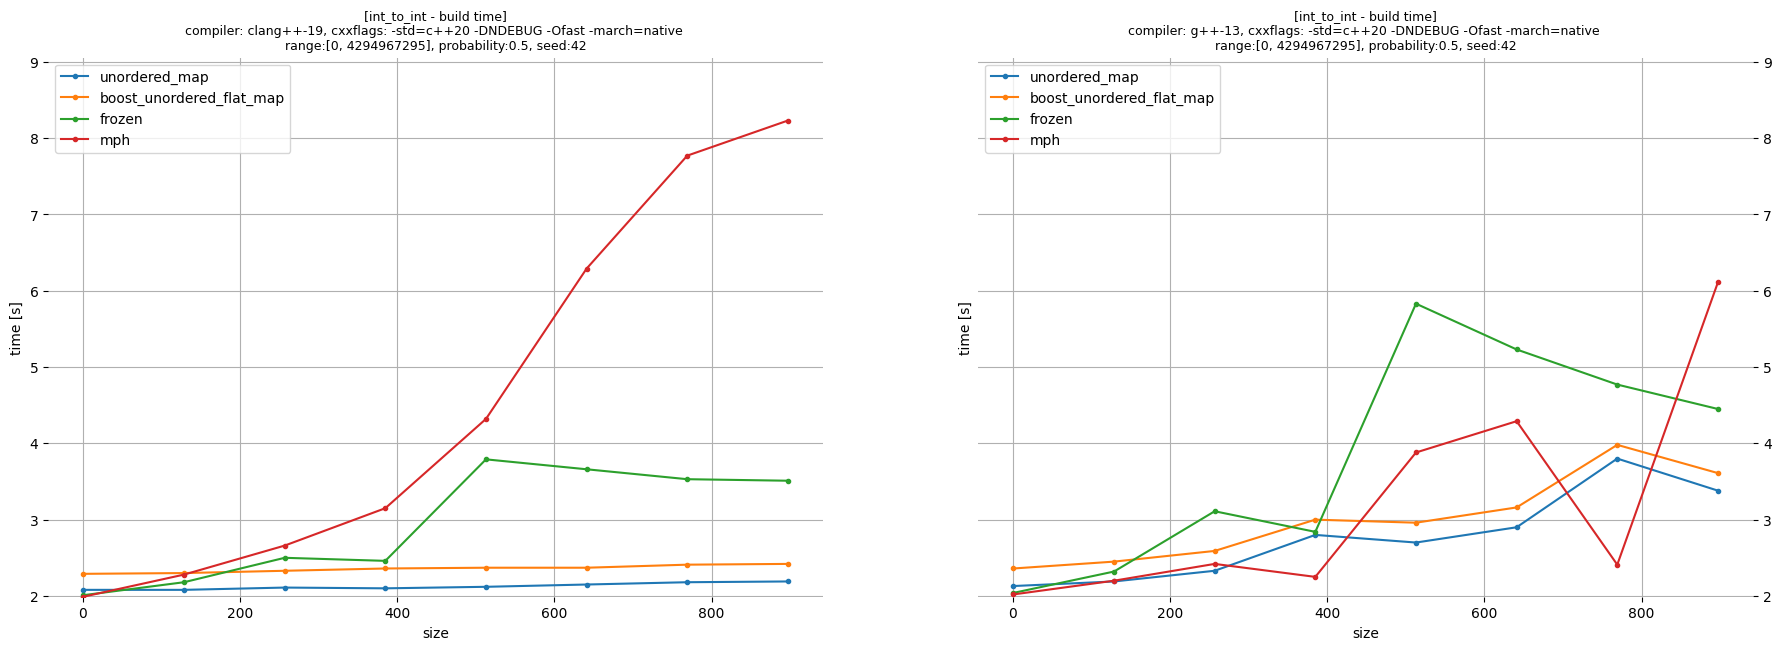

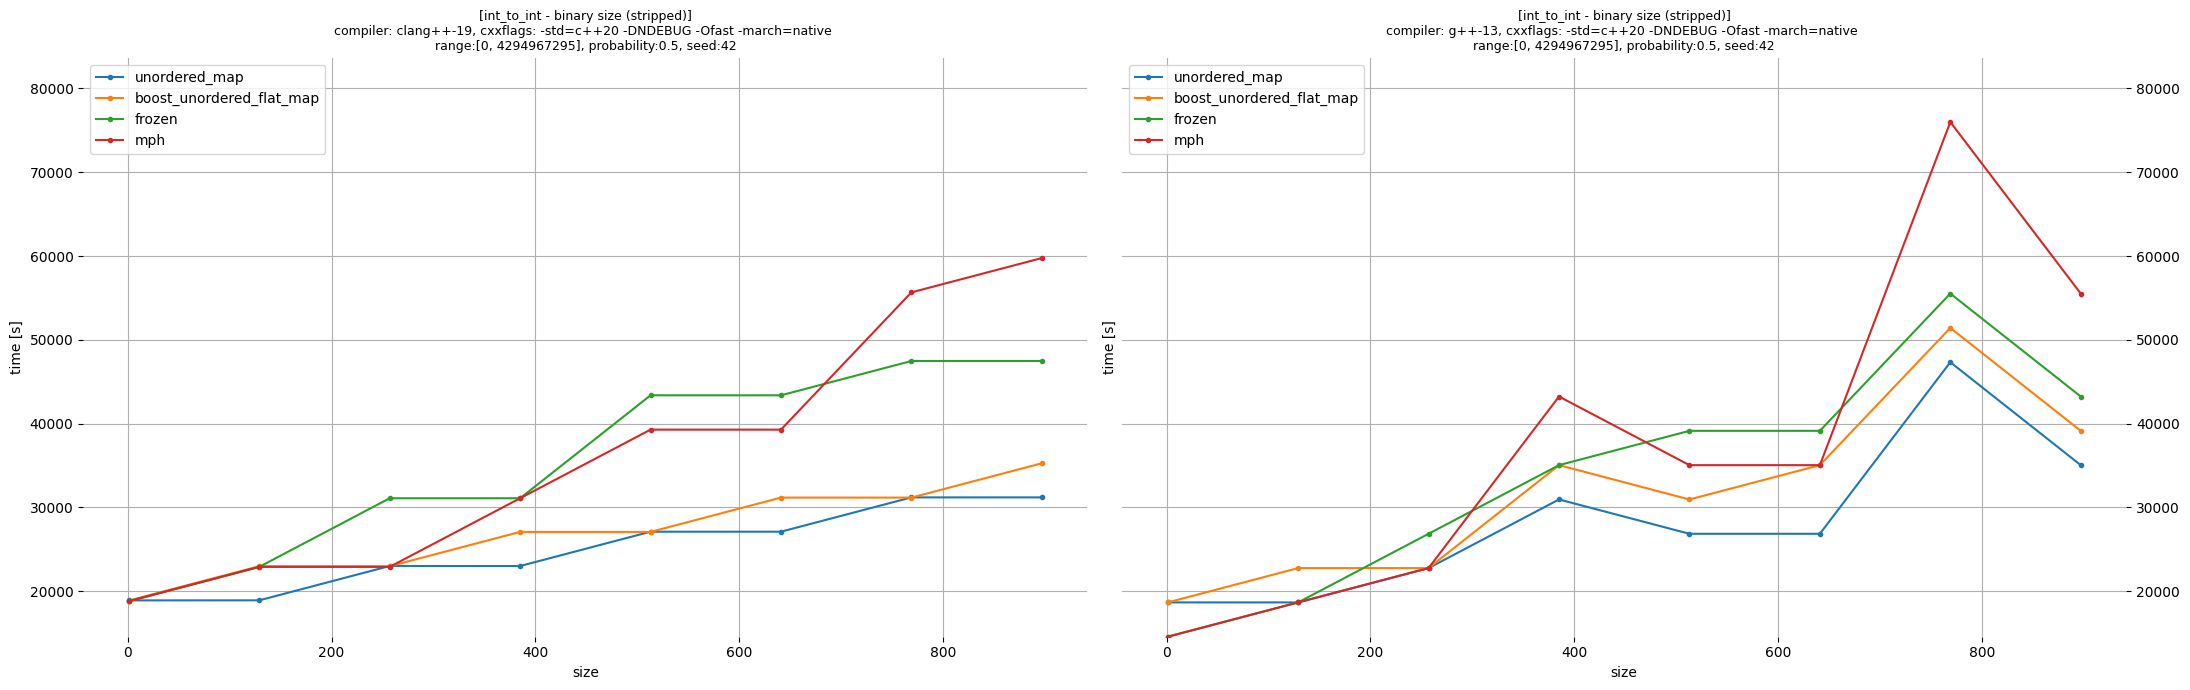

................................................................

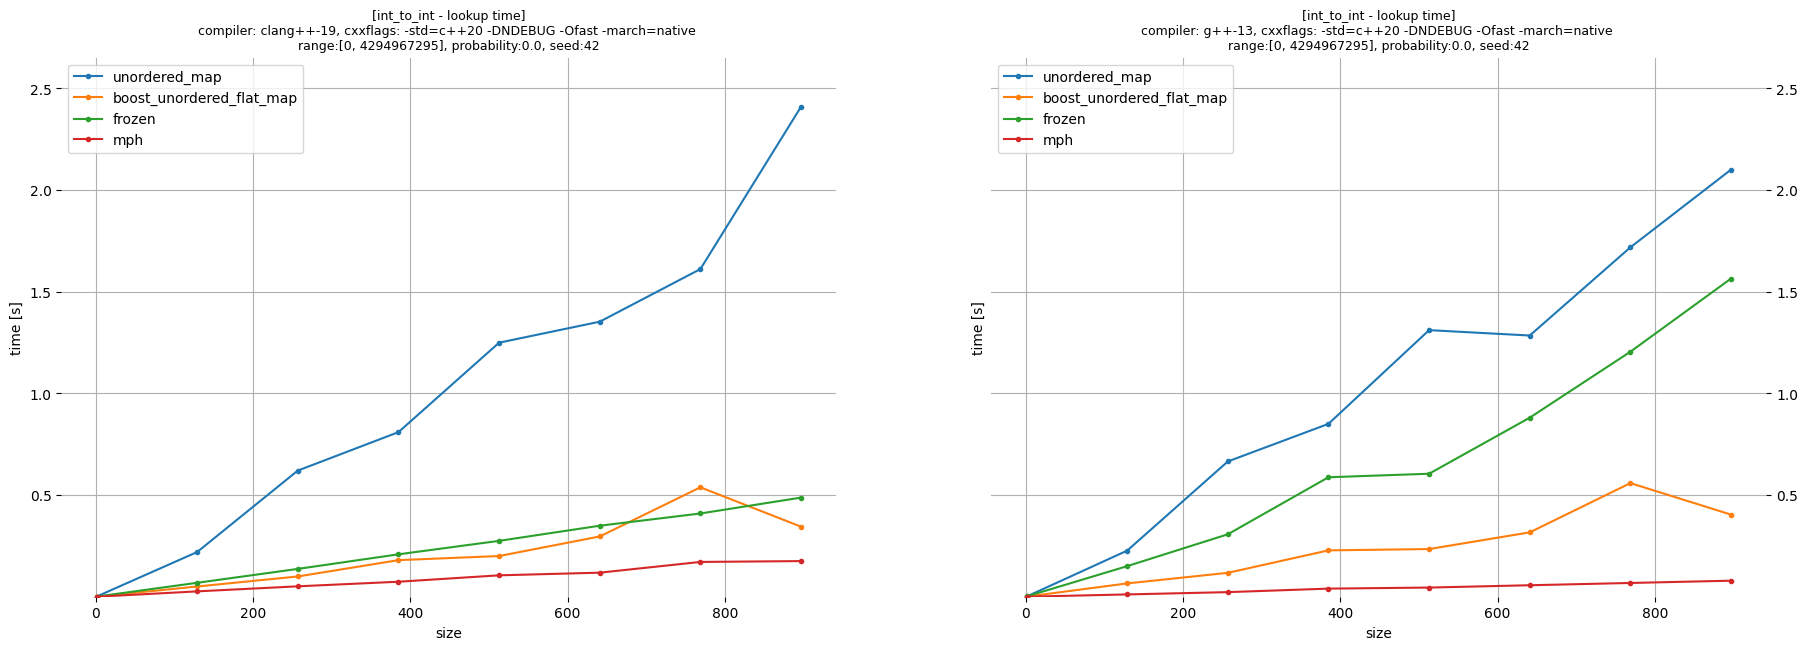

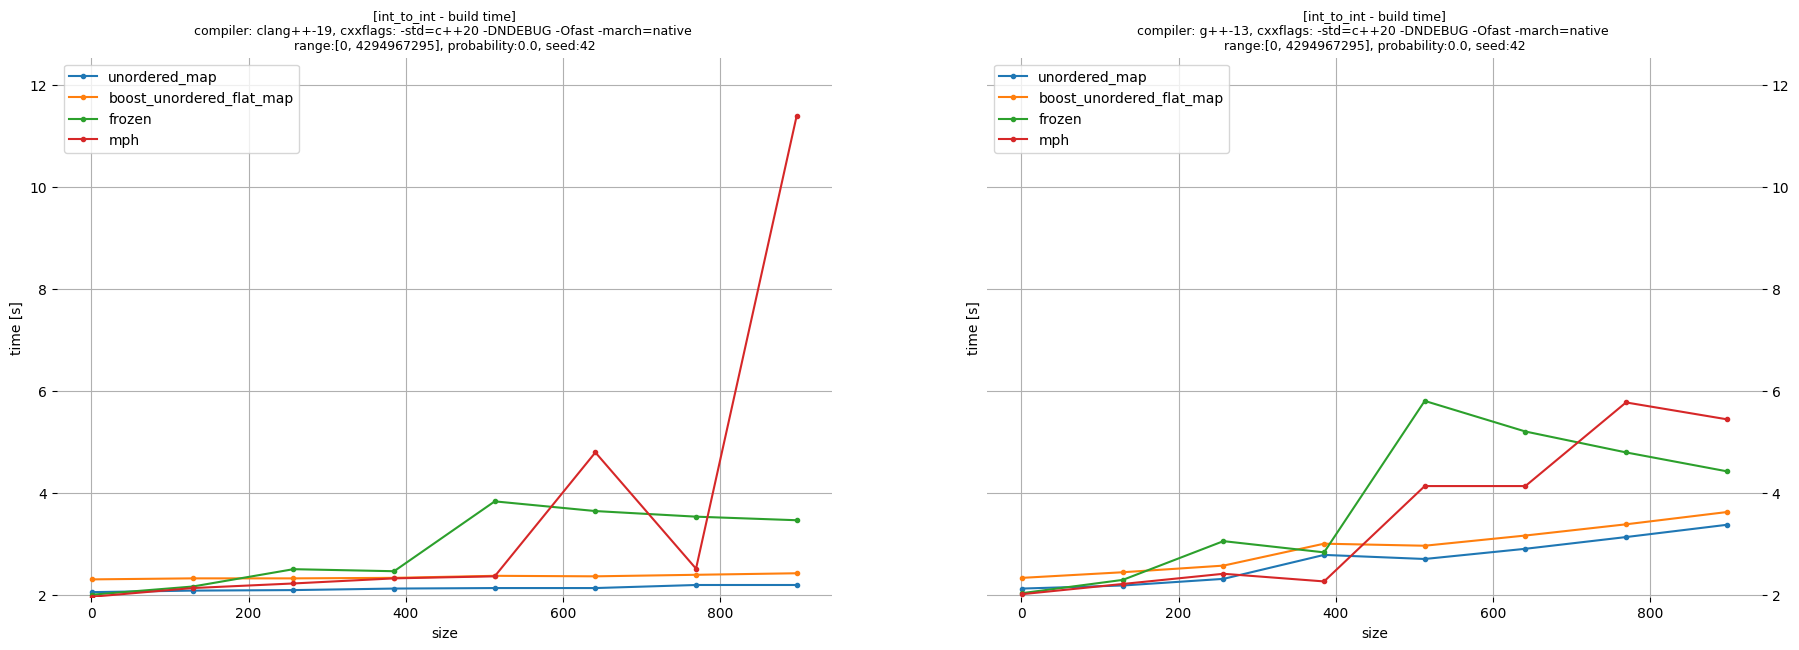

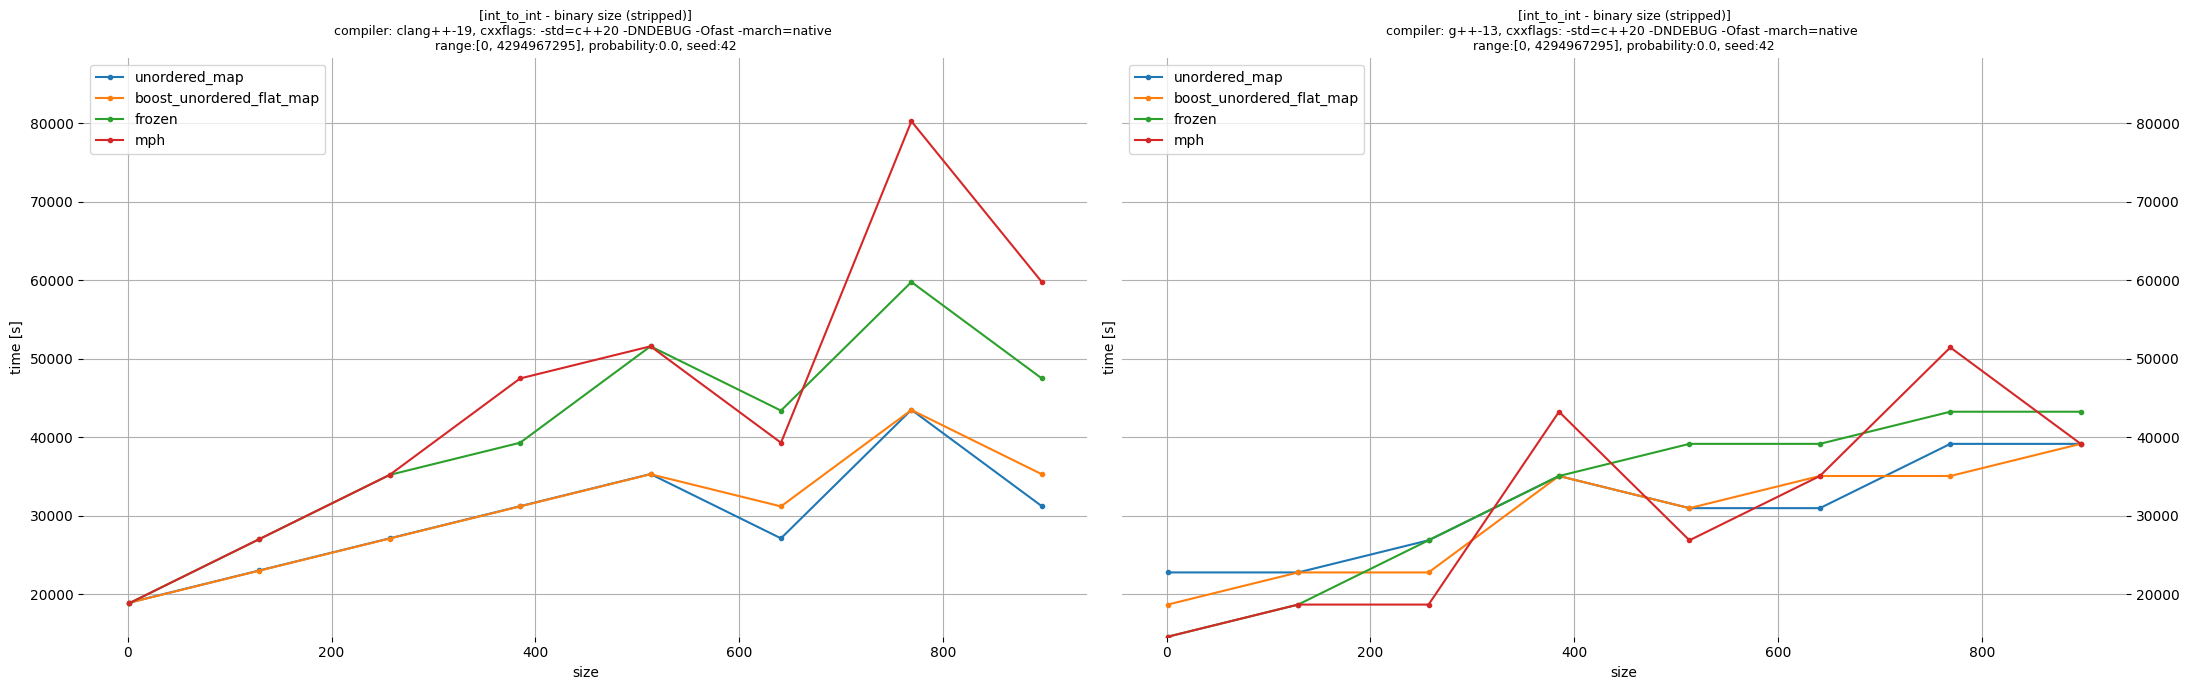

................................................................................................................

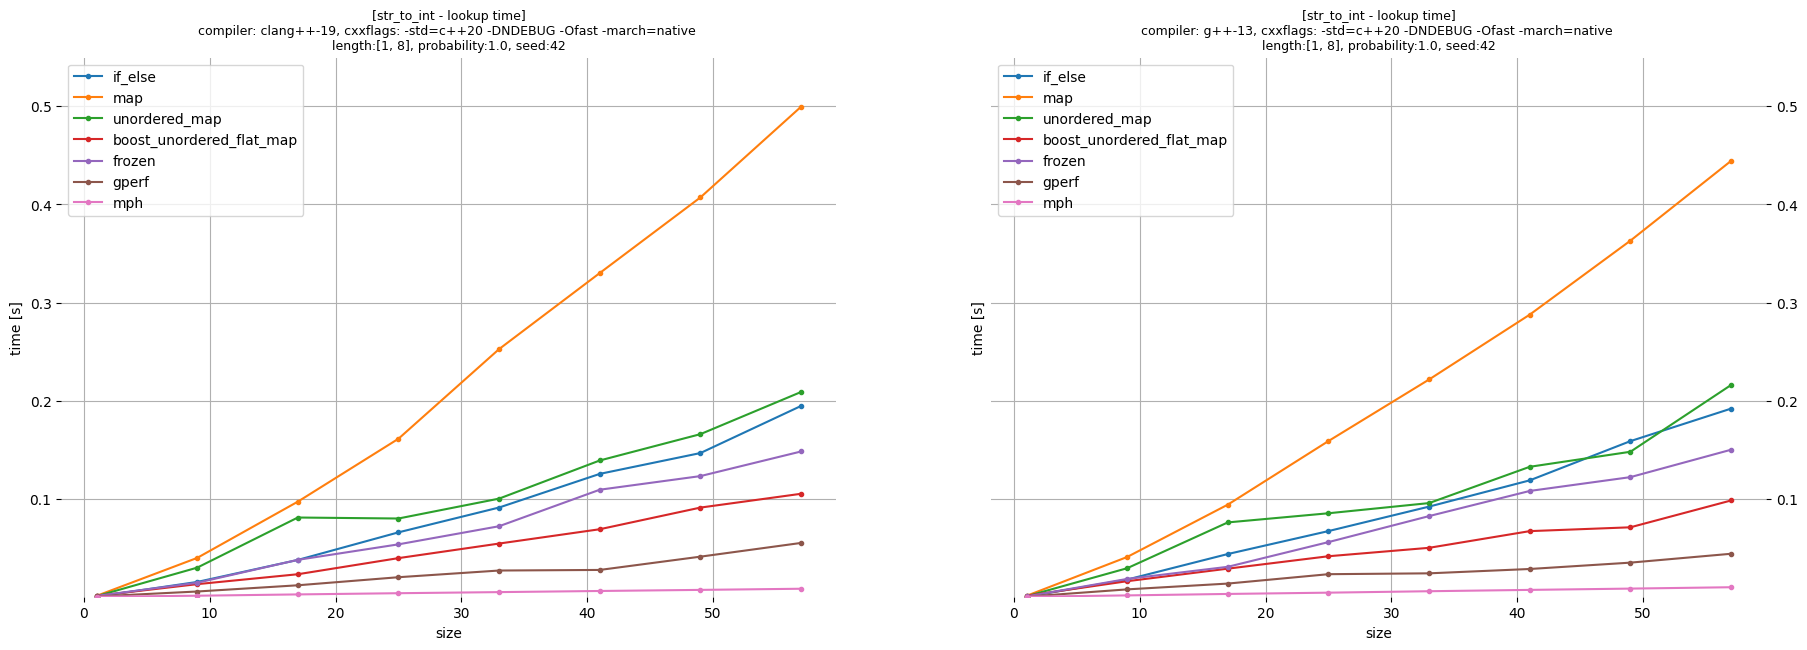

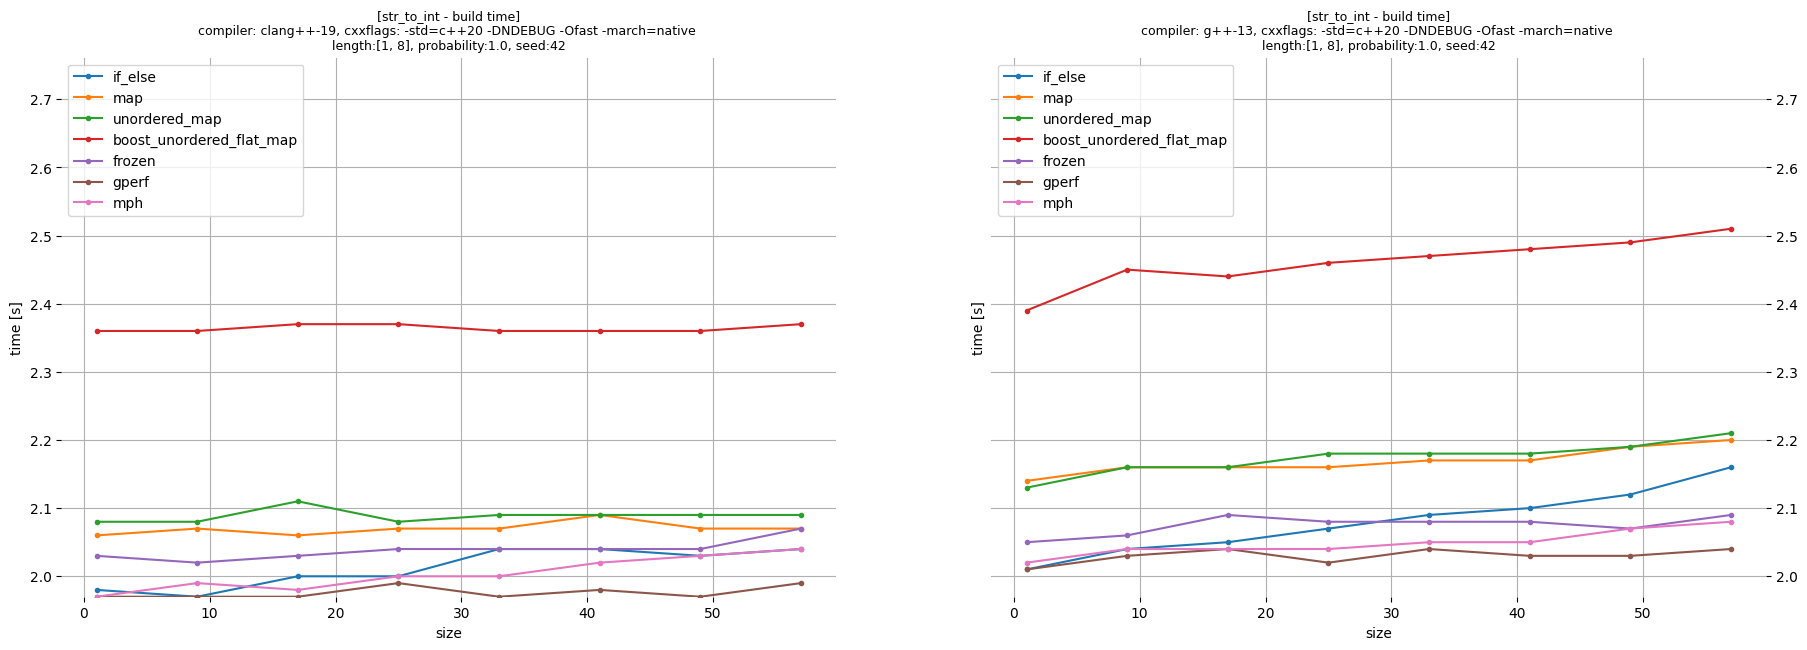

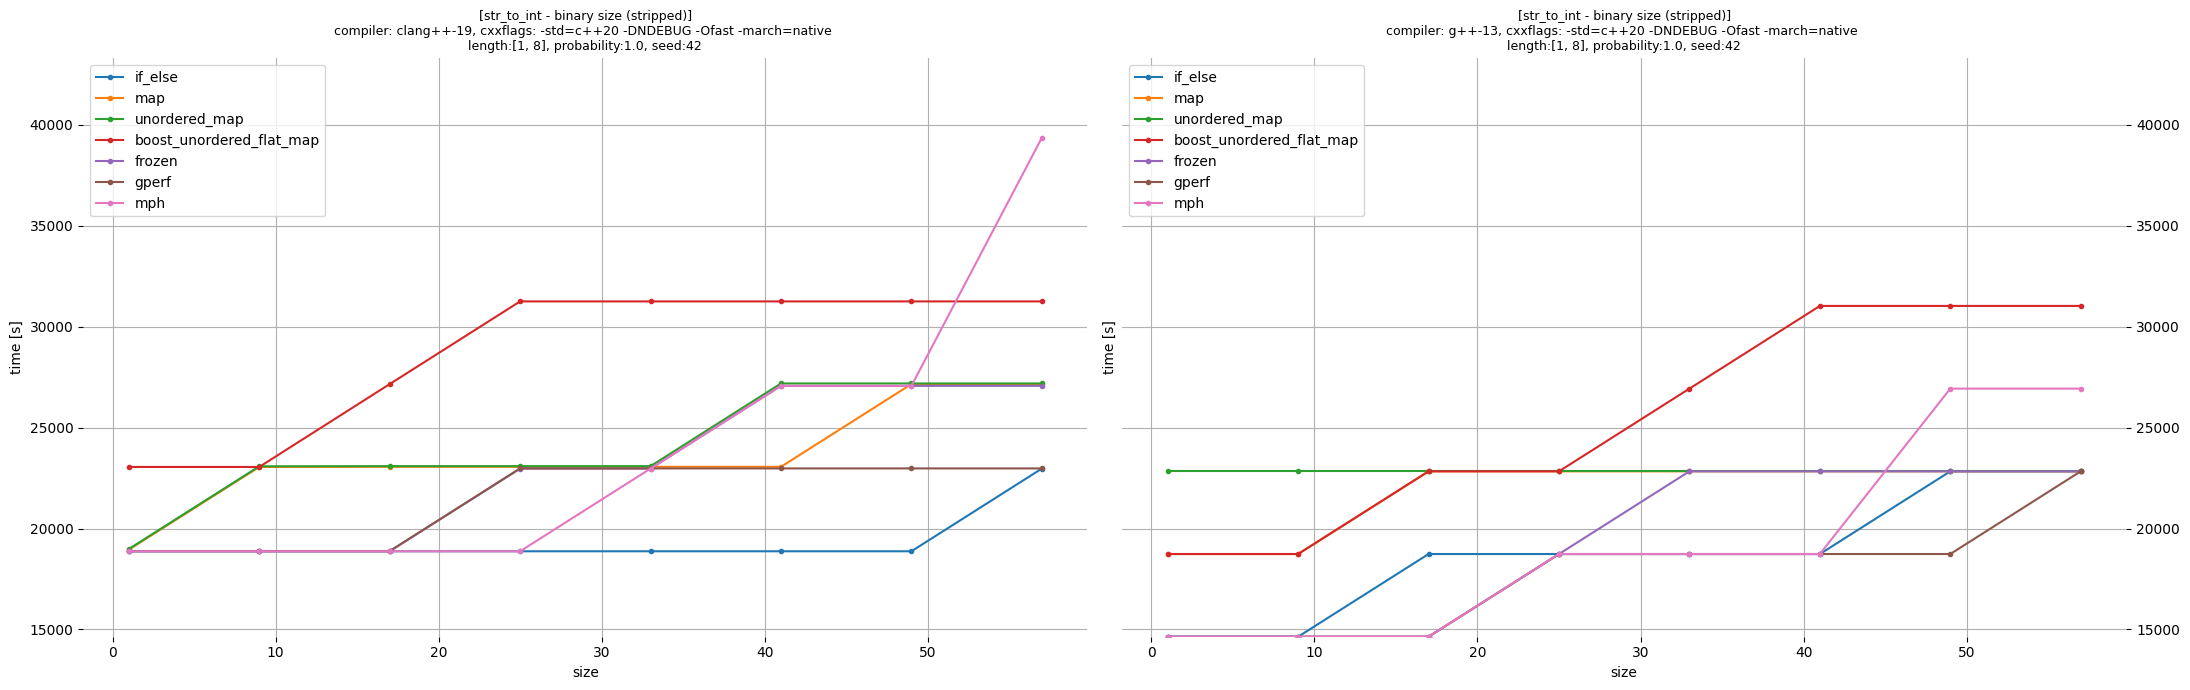

................................................................................................................

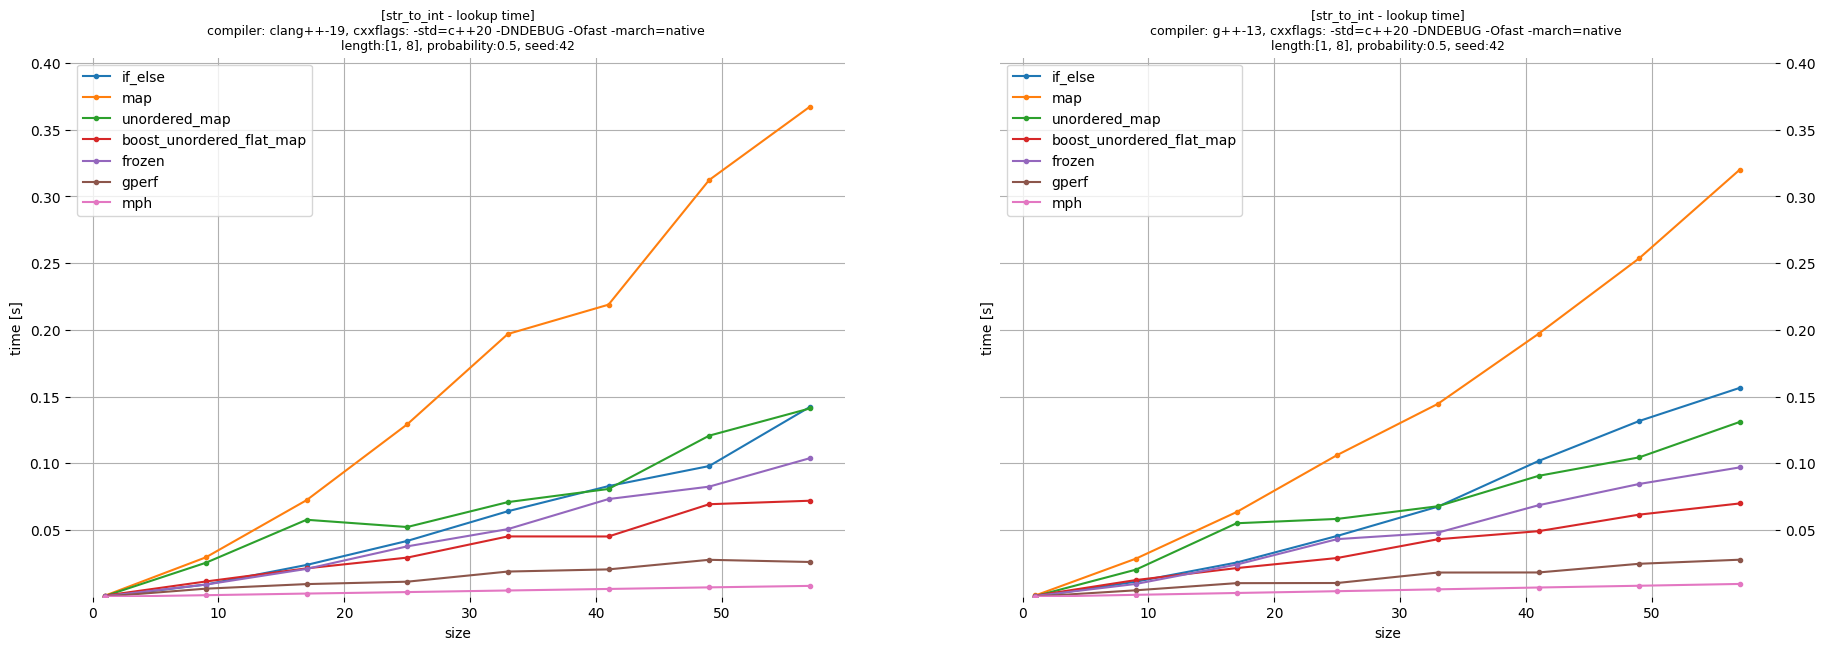

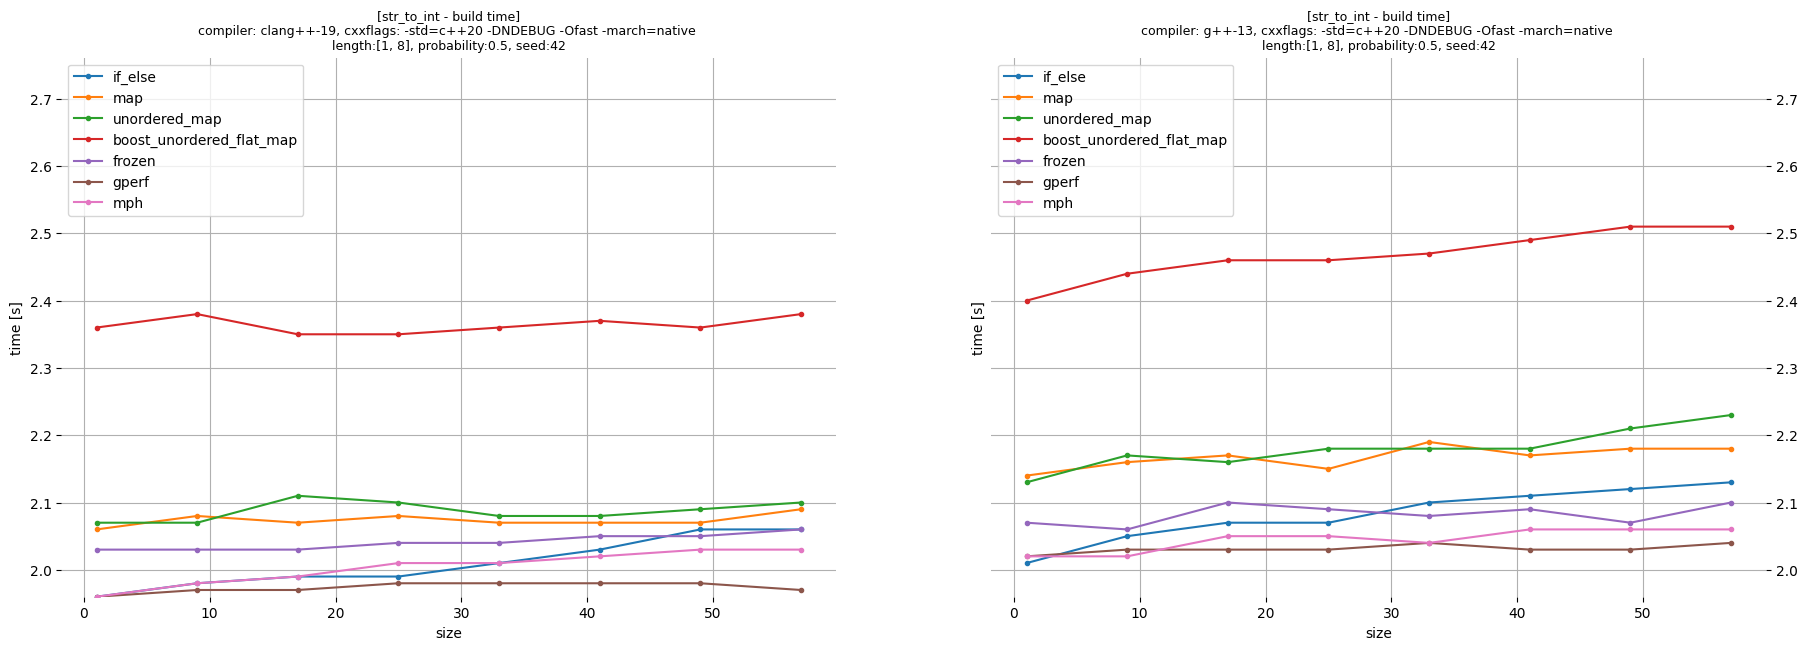

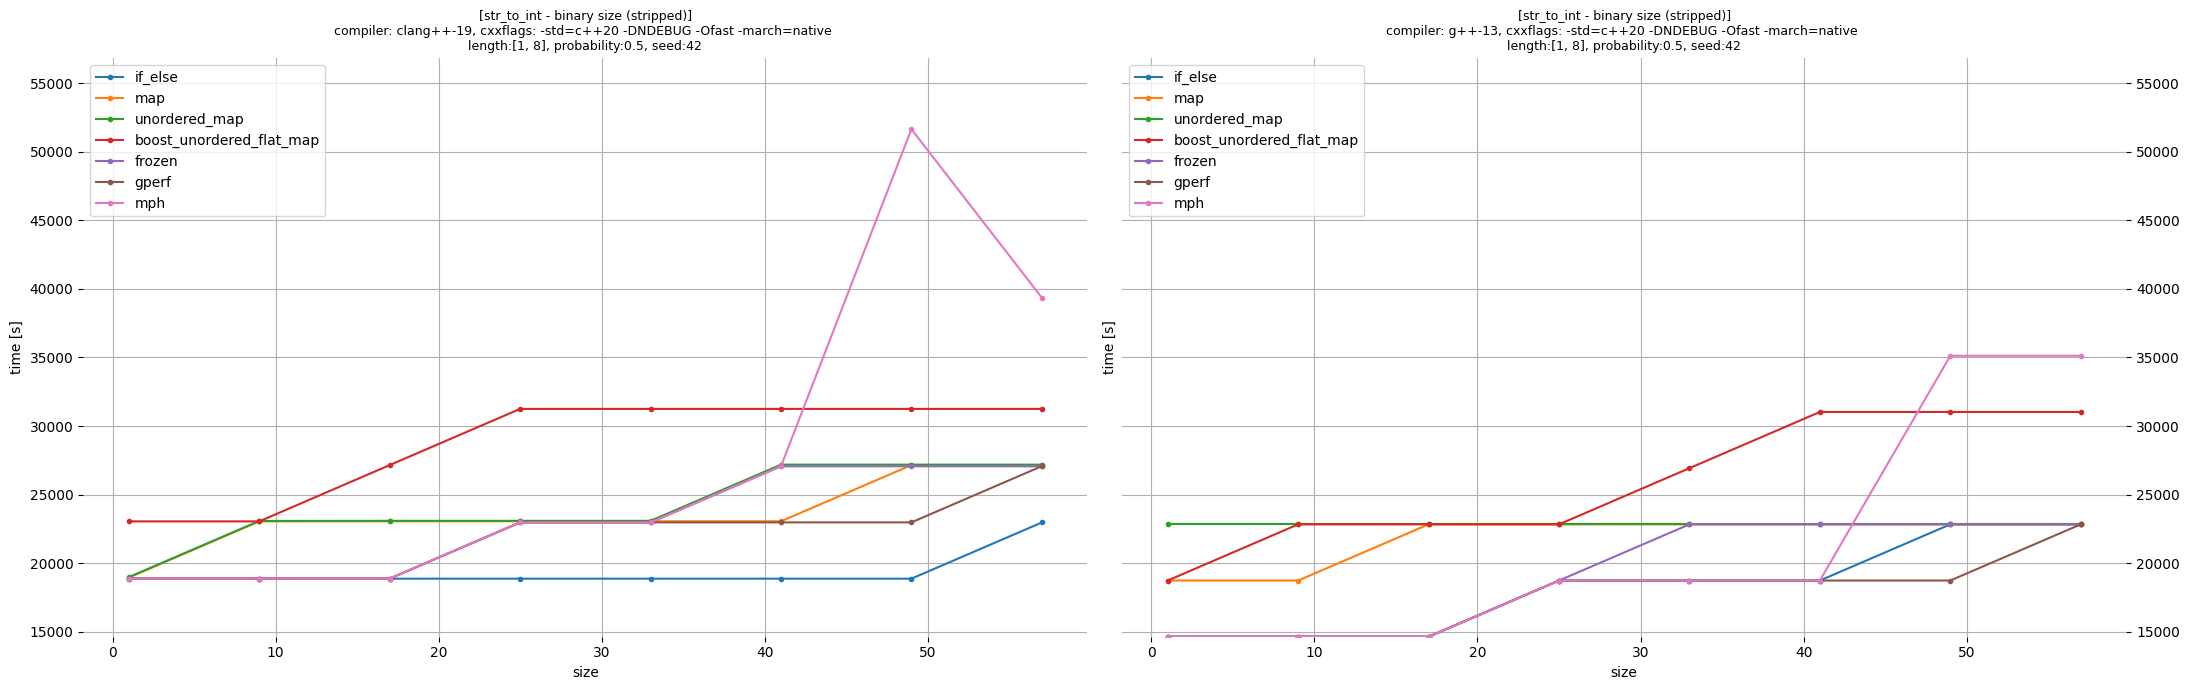

................................................................................................................

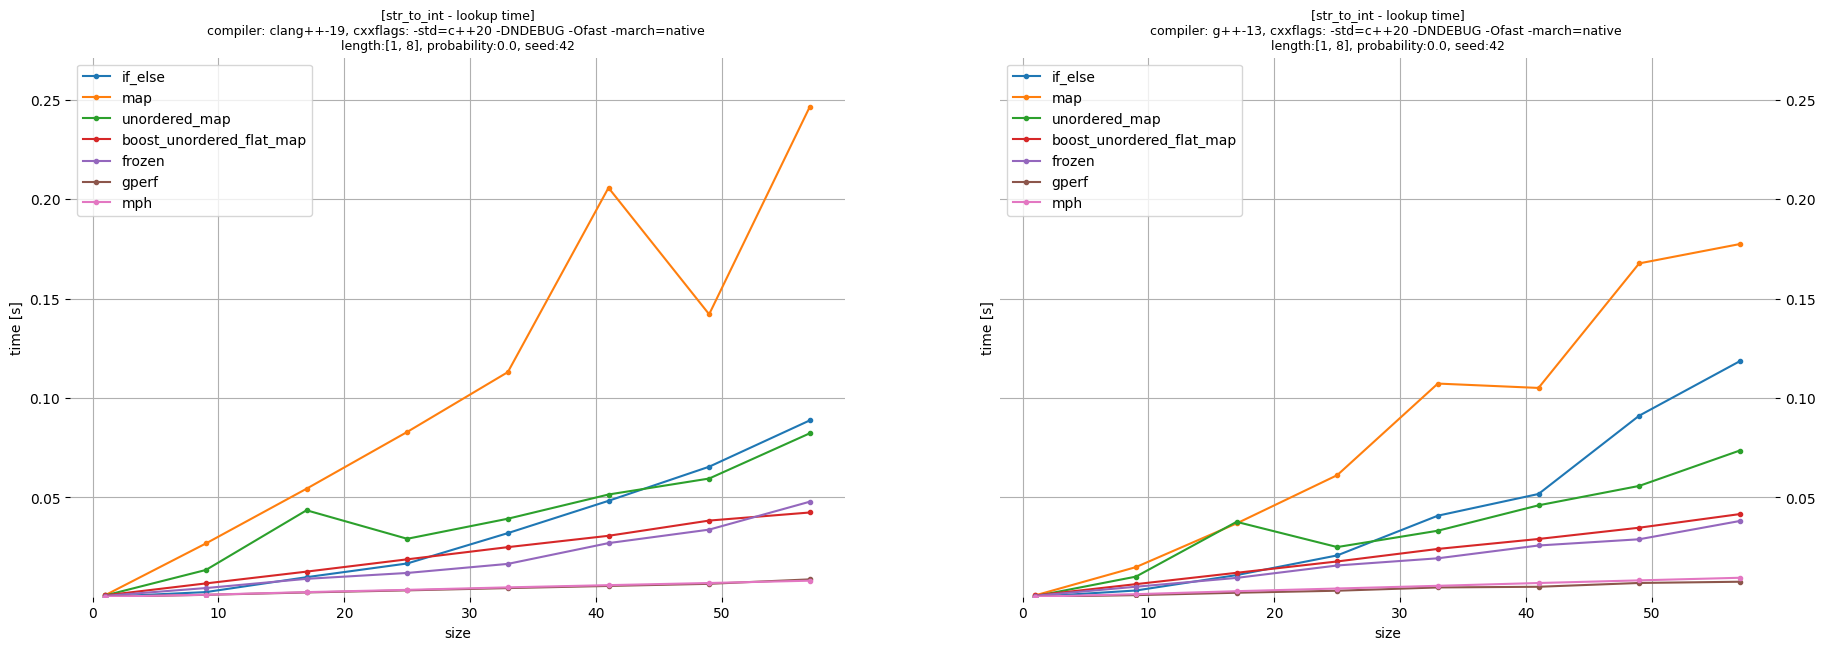

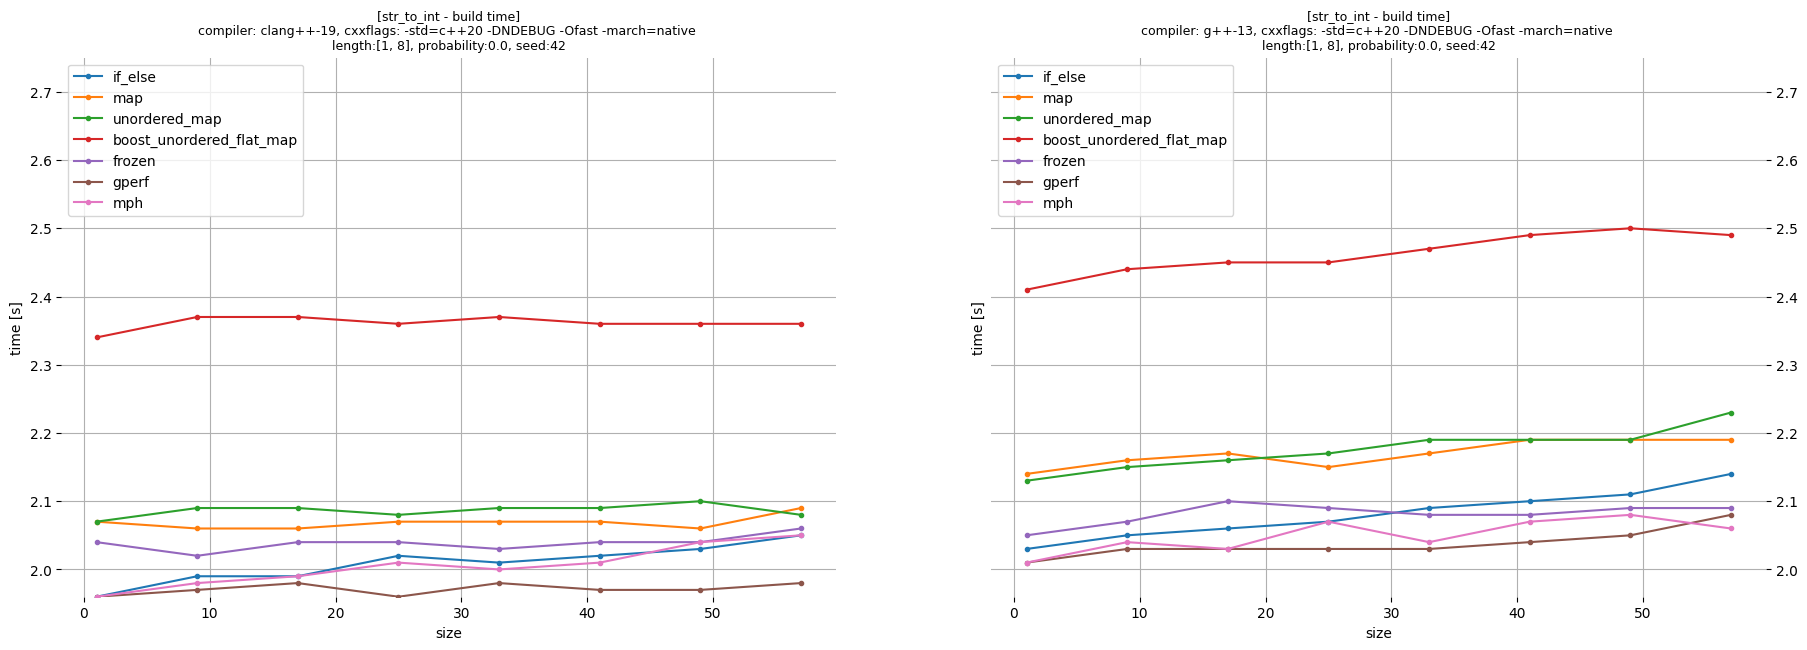

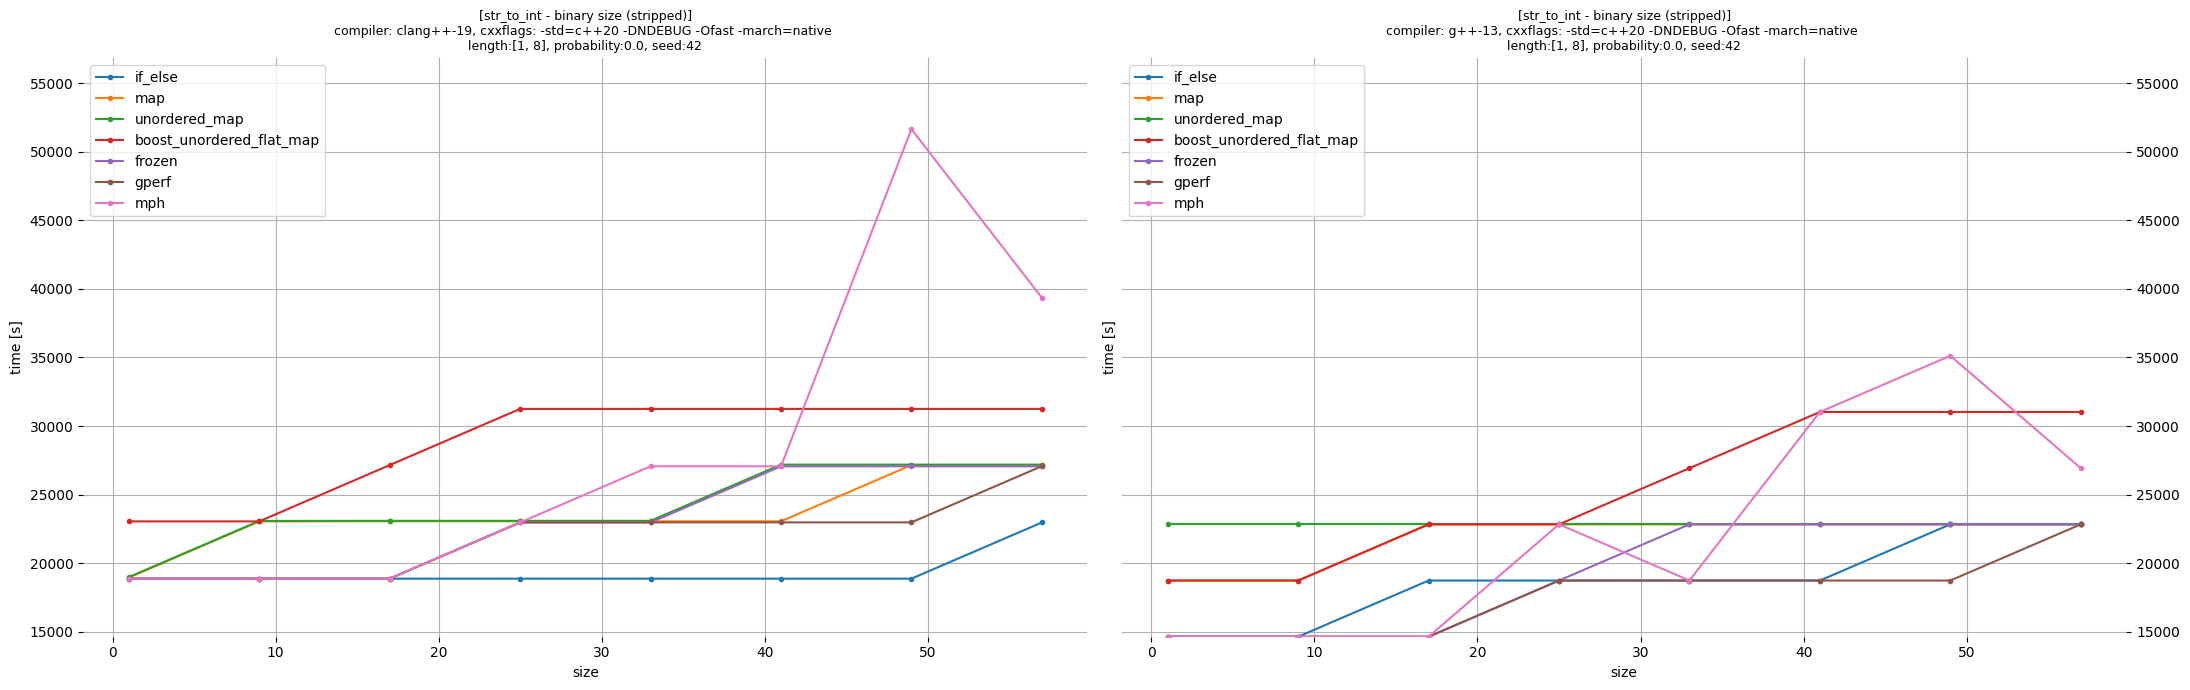

................................................................................

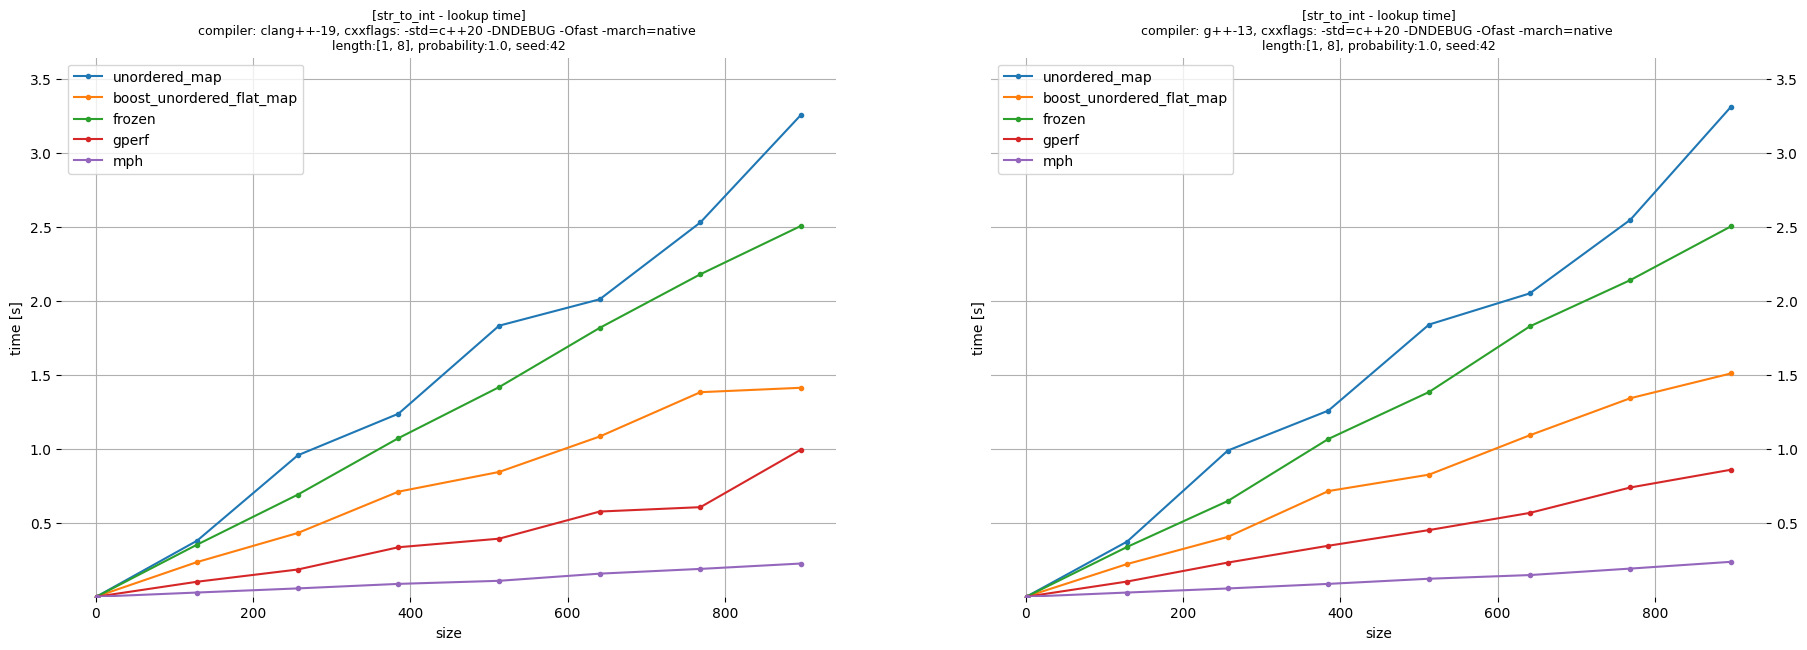

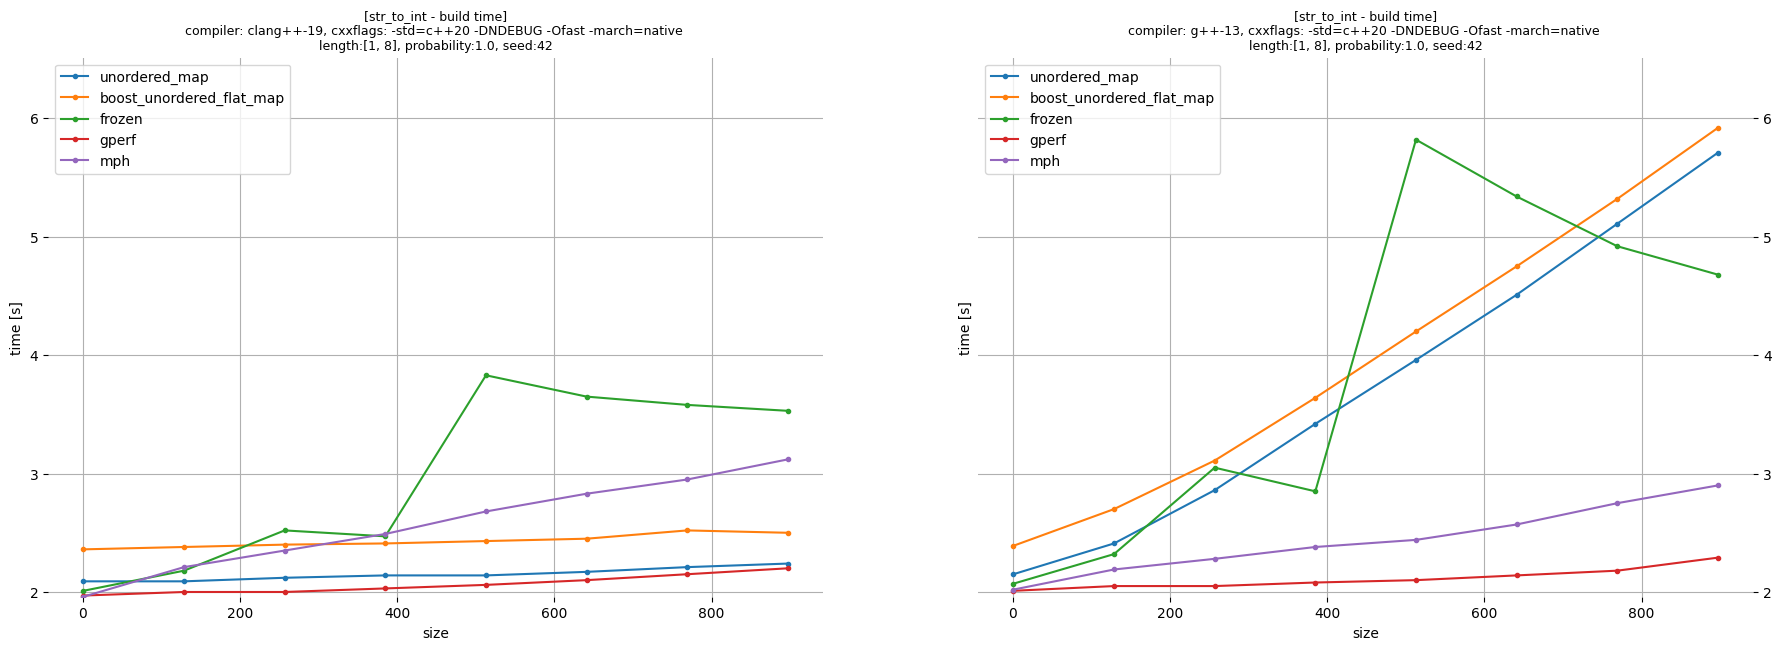

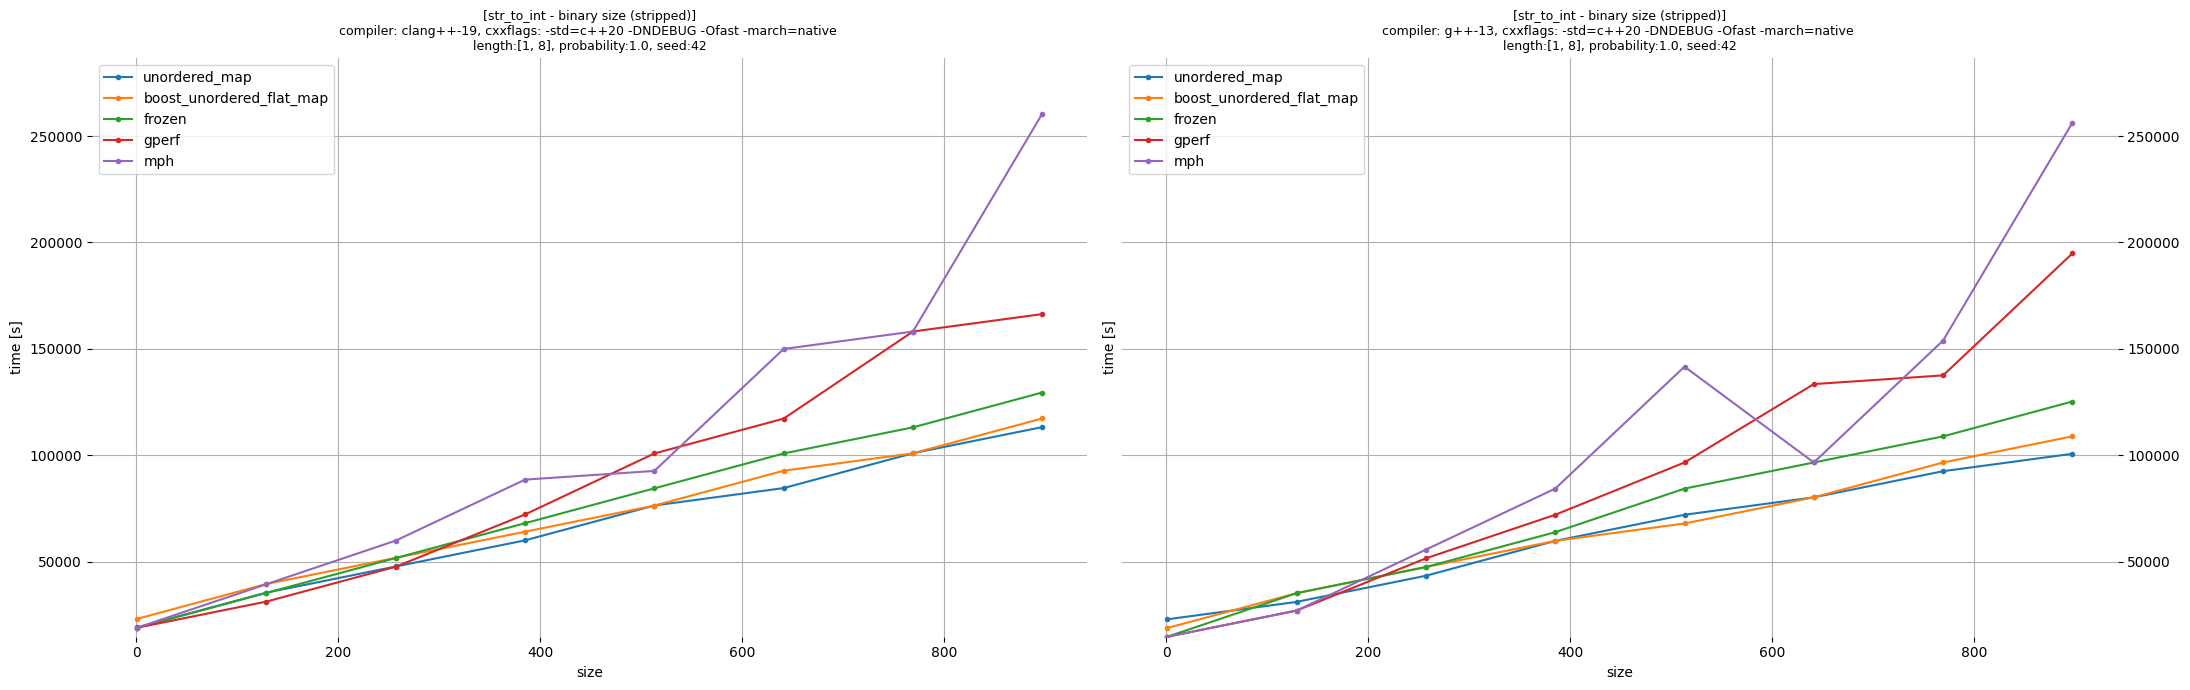

................................................................................

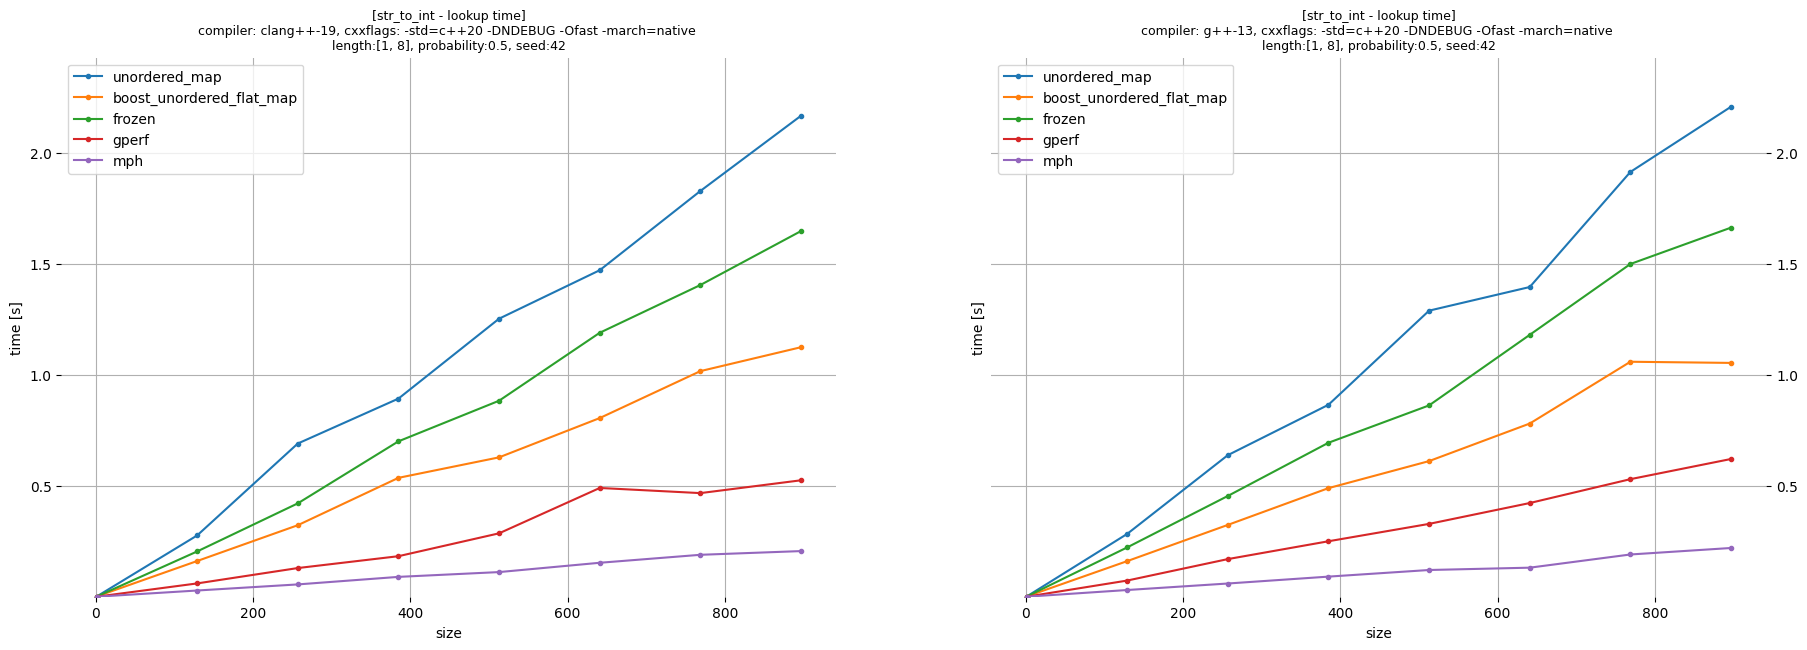

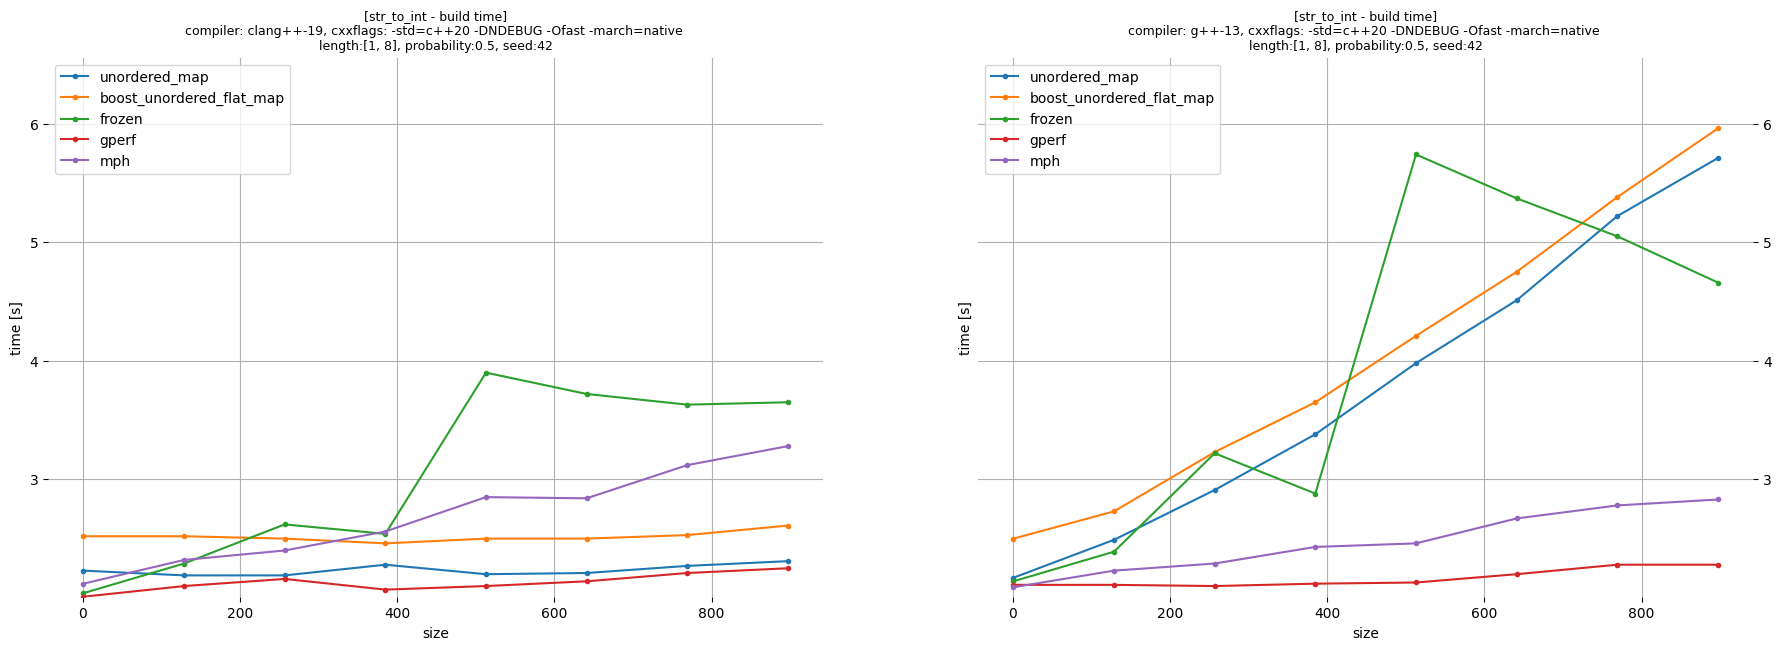

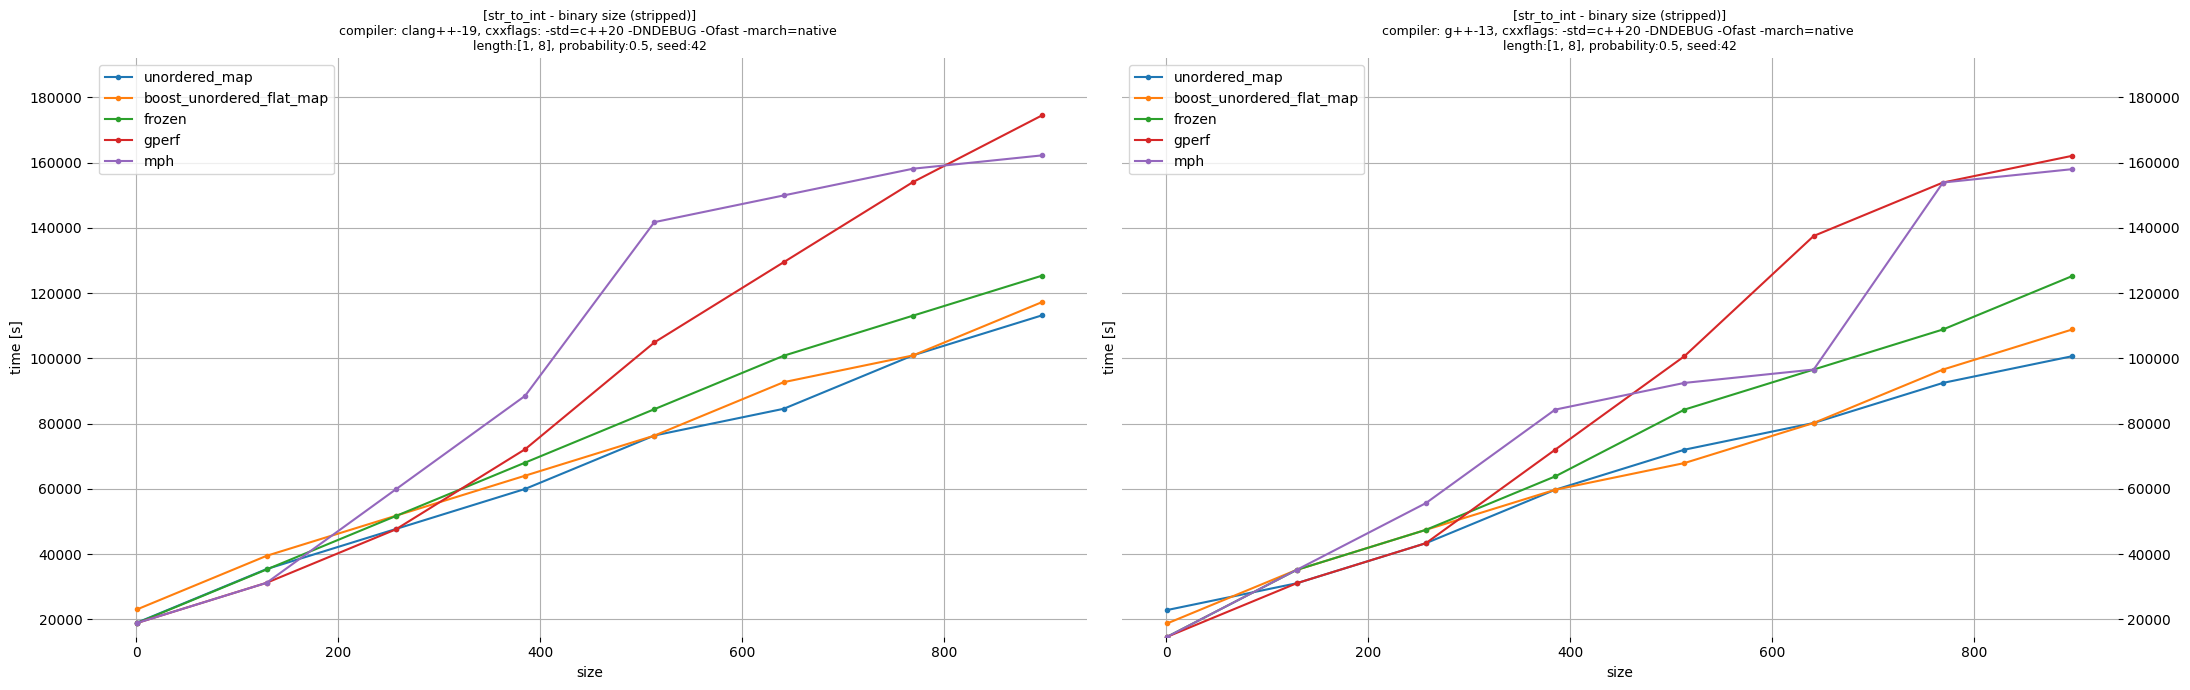

................................................................................

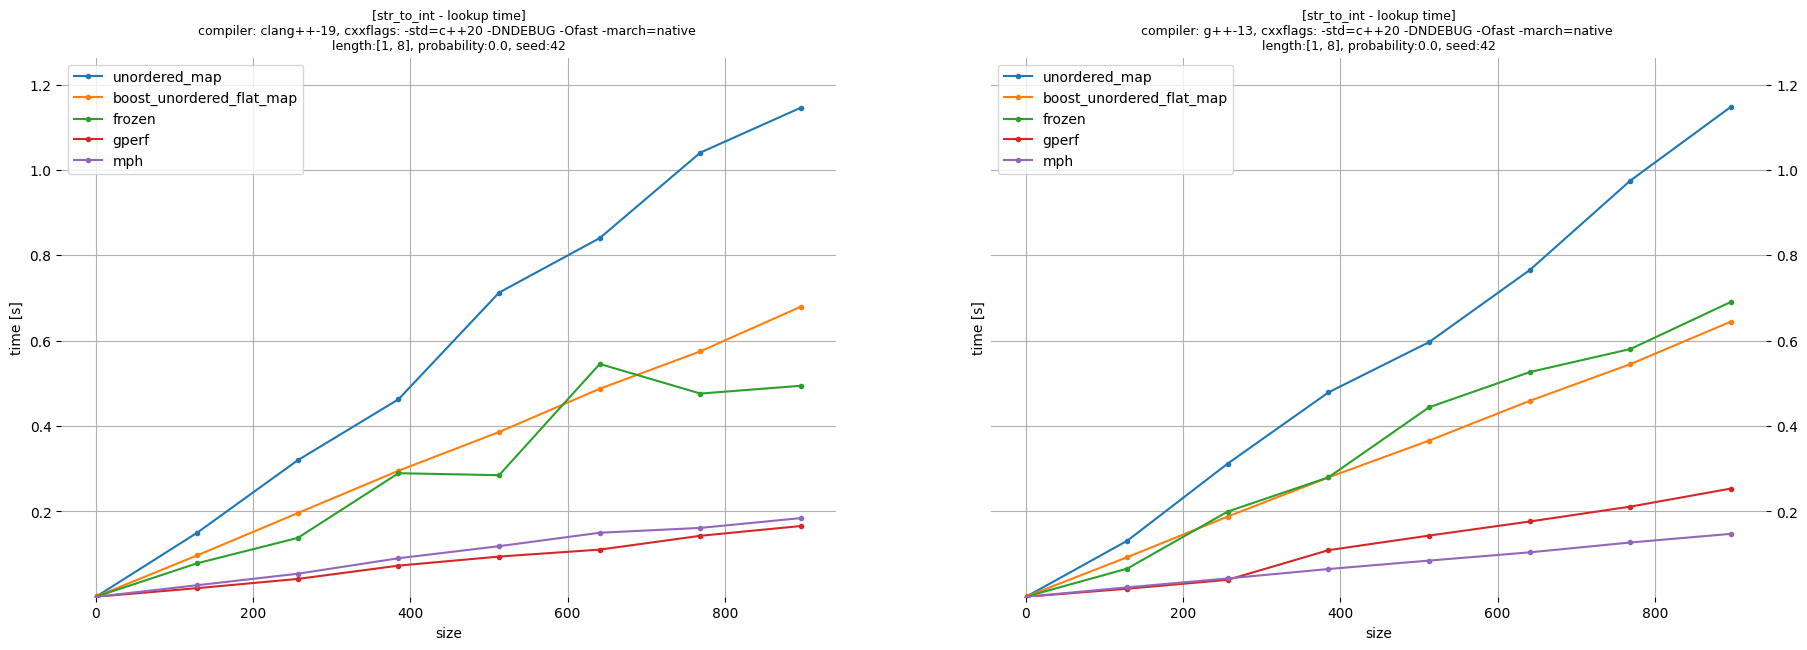

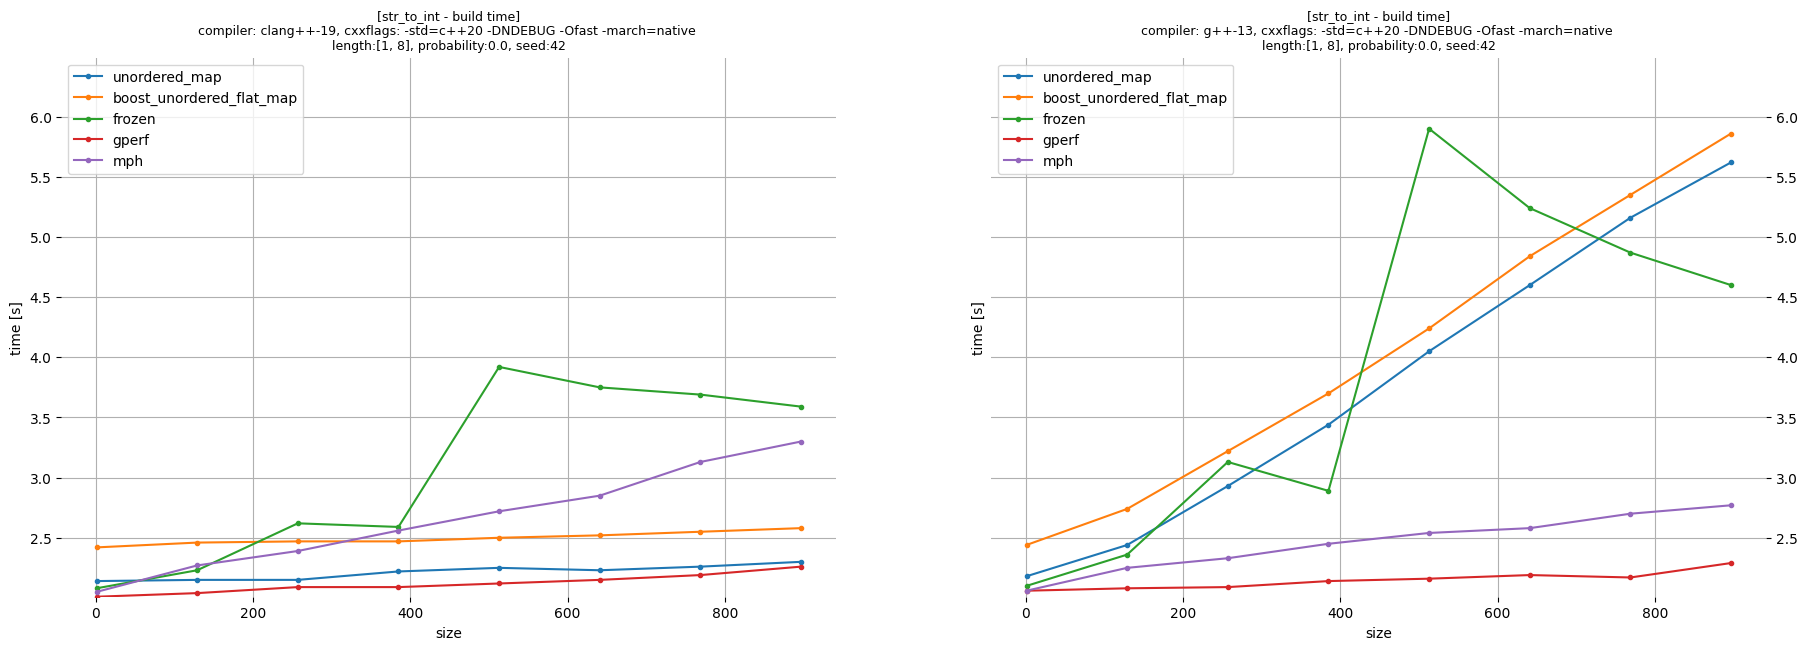

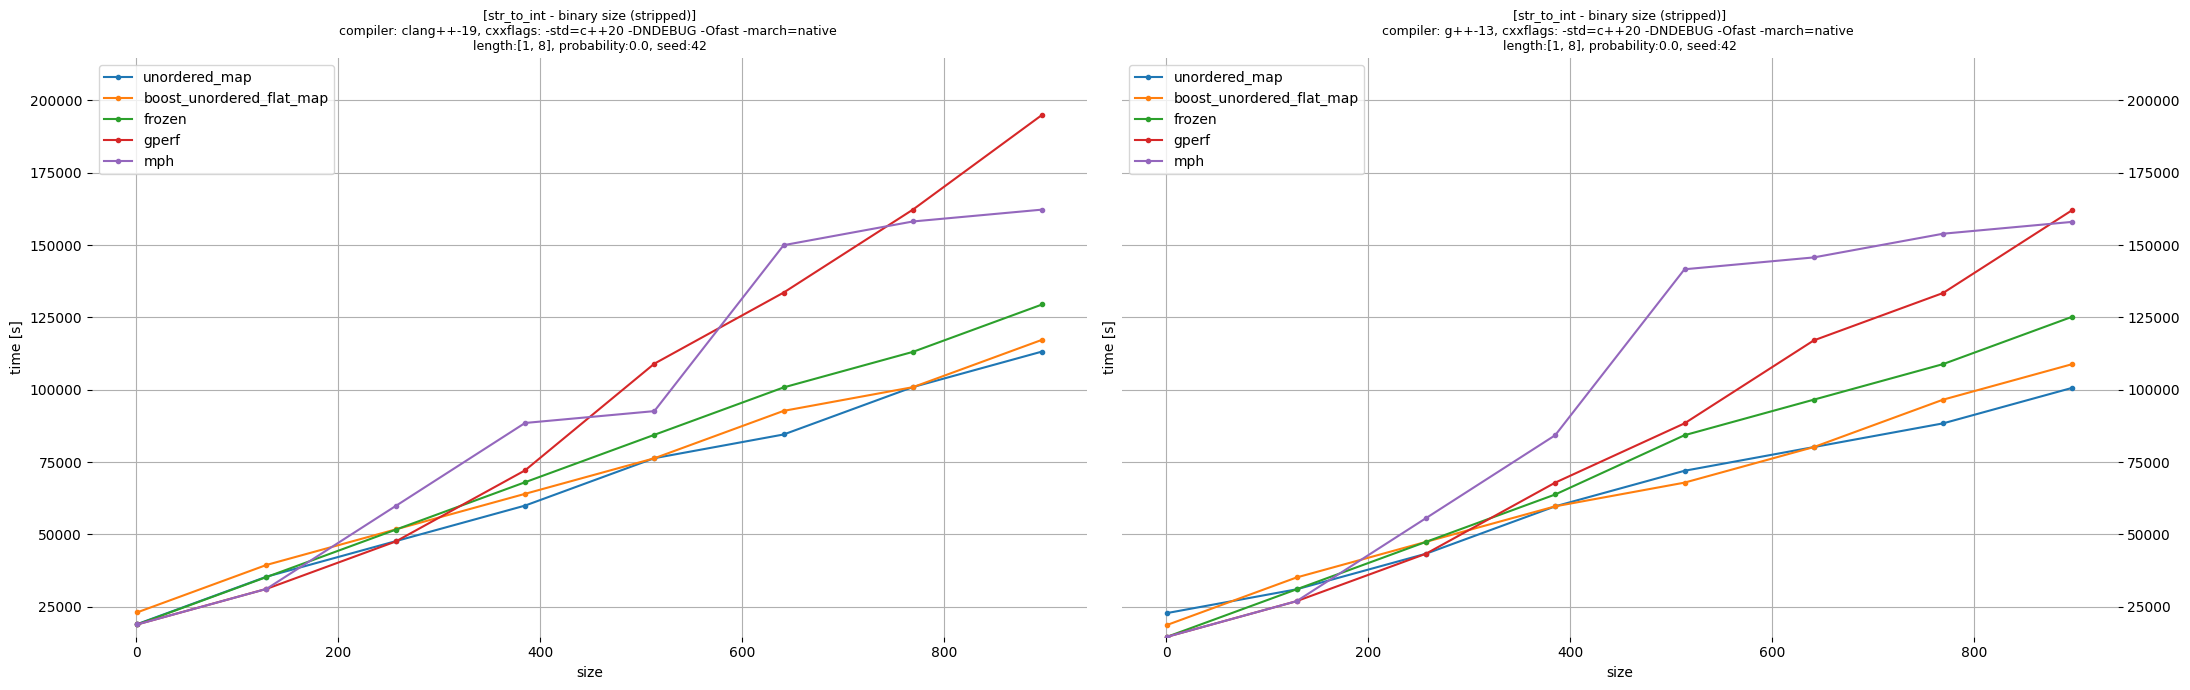

In [382]:
seed = 42

benchmark('str_to_int', ['clang++-19', 'g++-13'], ['if_else', 'map', 'unordered_map', 'boost_unordered_flat_map', 'frozen', 'gperf', 'mph'], sizes = range(1, 64, 8), combinations = [        
    {'length': [1, 8], 'probability': 1.00, 'seed': seed},
    {'length': [1, 8], 'probability': 0.50, 'seed': seed},
    {'length': [1, 8], 'probability': 0.00, 'seed': seed},
])

benchmark('str_to_int', ['clang++-19', 'g++-13'], ['unordered_map', 'boost_unordered_flat_map', 'frozen', 'gperf', 'mph'], sizes = range(1, 1024, 128), combinations = [        
    {'length': [1, 8], 'probability': 1.00, 'seed': seed},
    {'length': [1, 8], 'probability': 0.50, 'seed': seed},
    {'length': [1, 8], 'probability': 0.00, 'seed': seed},
])

benchmark('int_to_int', ['clang++-19', 'g++-13'], ['if_else', 'switch_case', 'map', 'unordered_map', 'boost_unordered_flat_map', 'frozen', 'mph'], sizes = range(1, 64, 8), combinations = [        
    {'range': [0, np.iinfo(np.uint16).max], 'probability': 1.00, 'seed': seed},
    {'range': [0, np.iinfo(np.uint16).max], 'probability': 0.50, 'seed': seed},
    {'range': [0, np.iinfo(np.uint16).max], 'probability': 0.00, 'seed': seed},
])

benchmark('int_to_int', ['clang++-19', 'g++-13'], ['unordered_map', 'boost_unordered_flat_map', 'frozen', 'mph'], sizes = range(1, 1024, 128), combinations = [        
    {'range': [0, np.iinfo(np.uint32).max], 'probability': 1.00, 'seed': seed},
    {'range': [0, np.iinfo(np.uint32).max], 'probability': 0.50, 'seed': seed},
    {'range': [0, np.iinfo(np.uint32).max], 'probability': 0.00, 'seed': seed},
])